# YTHDF2 project
---
## Data analysis for Ivayla Ivanova and Donal O Carroll 
---
# PYTHON 3 / R Notebook
### Adrien Leger / EMBL EBI
### Starting date 13/09/2016

---
## Import general package and definition of specific functions

In [18]:
# Standard lib imports
import os
from collections import OrderedDict
from glob import glob

# Local lib import
import pycl
import pyBioPlot as pbl
import pyBioUtil as pbu

# Third party import
import pandas as pd
import numpy as np
import pylab as pl

# Pyplot tweaking
%matplotlib inline
pl.rcParams['figure.figsize'] = 30, 10  # that's default image size for this interactive session

# Larger display 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# Allow to use R directly
%load_ext rpy2.ipython

# Simplify warning reporting to lighten the notebook style 
import warnings
warnings.formatwarning=(lambda message, *args: "{}\n".format(message))

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Previous analyses

* Comparison of WT and YTHDF2 KO oocytes "transcriptome" by Affy chips, at GV and MII stages.
    1.  246 genes overrepresented and 363 overrepresented between GV and MII in WT oocytes
    2.  101 genes overrepresented and 31 overrepresented at MII in YTHDF2 KO compared with WT but no correlation with the genes which are up or down in WT cells between the 2 stages


* GO term analysis of (2) did not really give any indication

* Up gene of (2) show enrichment of the m6A consensus around the stop codon

# Questions / Tasks

* Confirm the Affy analysis of GV and MII oocytes in WT cells (RNAseq not done in YTHDF2 KO)
* What are the characteristics of the up genes in the YTHDF2 KO MII oocytes (refined m6 consensus, RNA structure, UTR len, advanced ontology analysis...)
* Is there an ongoing transcription in GV oocytes and of what genes (spliced vs unspliced forms)?
* ...

# Bioinfo Analyses

In [27]:
# create initial folder
main_dir = "/home/aleg/Data/Datasets/YTHDF2_Ivayla/"
pycl.mkdir(main_dir)
os.chdir(main_dir)

# create subdir
dir_list= ["data", "index", "info", "reference", "alignment", "QC"]
for d in dir_list:
    pycl.mkdir(d)

Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/QC


## Available data and references

### RNAseq

I got the RNAseq fastq files from Ivayla for the GV and MII oocytes in the WT cell lines. There are 3 replicates per conditions

In [26]:
sample_file = "./info/Sample_sheet.tsv"
pd.read_table(sample_file)

,strain,stage,oocyte,RNA_sample,R1_file,R2_file
0,B6N,GV Oocytes,65,26IIR,~/Data/Datasets/YTHDF2_Ivayla/data/26IIR_1.fas...,~/Data/Datasets/YTHDF2_Ivayla/data/26IIR_2.fas...
1,B6N,GV Oocytes,57,27IIR,~/Data/Datasets/YTHDF2_Ivayla/data/27IIR_1.fas...,~/Data/Datasets/YTHDF2_Ivayla/data/27IIR_2.fas...
2,B6N,GV Oocytes,50,42IIR,~/Data/Datasets/YTHDF2_Ivayla/data/42IIR_1.fas...,~/Data/Datasets/YTHDF2_Ivayla/data/42IIR_2.fas...
3,B6N,MII Oocytes,50,32IIR,~/Data/Datasets/YTHDF2_Ivayla/data/32IIR_1.fas...,~/Data/Datasets/YTHDF2_Ivayla/data/32IIR_2.fas...
4,B6N,MII Oocytes,65,40IIR,~/Data/Datasets/YTHDF2_Ivayla/data/40IIR_1.fas...,~/Data/Datasets/YTHDF2_Ivayla/data/40IIR_2.fas...
5,B6N,MII Oocytes,50,41IIR,~/Data/Datasets/YTHDF2_Ivayla/data/41IIR_1.fas...,~/Data/Datasets/YTHDF2_Ivayla/data/41IIR_2.fas...


### Reference genome files

I dowloaded the last mouse genome transcript reference fasta file from Gencode : Release M10 (GRCm38.p4), containing the Nucleotide sequences of all transcripts on the reference chromosomes

In [11]:
reference_file = "./reference/gencode.vM10.transcripts.fa.gz"
pycl.wget("ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_mouse/release_M10/gencode.vM10.transcripts.fa.gz", reference_file)

Downloading: ftp://ftp.sanger.ac.uk/pub/gencode/Gencode_mouse/release_M10/gencode.vM10.transcripts.fa.gz	Bytes: 36445984
36.4 MB Downloaded	[100 %]


'./reference/gencode.vM10.transcripts.fa.gz'

## Alignments of read at transcript level with Kalisto

### Clean gencode datasets and generates gene info file

In [13]:
original_gencode_fasta = "./reference/gencode.vM10.transcripts.fa.gz"
gencode_transcript_info = "./reference/gencode.vM10.transcripts.tsv"
clean_gencode_fasta = "./reference/gencode.vM10.transcripts_clean.fa.gz"

print("Generates a transcript info list")
pbu.gencode_fasta_info(original_gencode_fasta, gencode_transcript_info)
pycl.head(gencode_transcript_info, 5)

print("Clean fasta reference")
pbu.gencode_fasta_clean(original_gencode_fasta, clean_gencode_fasta)
pycl.head(clean_gencode_fasta, 4)

Generates a transcript info list
Found 117667 Sequences
GENCODE_transcript_id	GENCODE_gene_id	HAVANA_gene_id	HAVANA_transcript_id	transcript_name	gene_name	length	RNA_type
ENSMUST00000193812.1	ENSMUSG00000102693.1	OTTMUSG00000049935.1	OTTMUST00000127109.1	4933401J01Rik-001	4933401J01Rik	1070	TEC	
ENSMUST00000082908.1	ENSMUSG00000064842.1	-	-	Gm26206-201	Gm26206	110	snRNA	
ENSMUST00000162897.1	ENSMUSG00000051951.5	OTTMUSG00000026353.2	OTTMUST00000086625.1	Xkr4-003	Xkr4	4153	processed_transcript	
ENSMUST00000159265.1	ENSMUSG00000051951.5	OTTMUSG00000026353.2	OTTMUST00000086624.1	Xkr4-002	Xkr4	2989	processed_transcript	

Clean fasta reference
Found 117667 Sequences
>ENSMUST00000193812.1
AAGGAAAGAGGATAACACTTGAAATGTAAATAAAGAAAATACCTAATAAAAATAAATAAAAACATGCTTTCAAAGGAAATAAAAAGTTGGATTCAAAAATTTAACTTTTGCTCATTTGGTATAATCAAGGAAAAGACCTTTGCATATAAAATATATTTTGAATAAAATTCAGTGGAAGAATGGAATAGAAATATAAGTTTAATGCTAAGTATAAGTACCAGTAAAAGAATAATAAAAAGAAATATAAGTTGGGTATACAGTTATTTGCCAGCACAAAGCCTTGGGTATGGTTCTTAGCACTAAGGAA

### Generate index for kalisto

In [21]:
program = "kallisto-0.43 index"
index_file = "./index/gencode_vM10_all_transcripts.idx"
index_report_file = "./index/gencode_vM10_all_transcripts.txt"
fasta = "./reference/gencode.vM10.transcripts_clean.fa.gz"

# Prepare the command line
cmd = "{} -i {} {}".format(program, index_file, fasta)
print (cmd)

# Run bash command
! {cmd}

kallisto-0.43 index -i ./index/gencode_vM10_all_transcripts.idx ./reference/gencode.vM10.transcripts_clean.fa.gz

[build] loading fasta file ./reference/gencode.vM10.transcripts_clean.fa.gz
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 575 target sequences
[build] warning: replaced 3 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 672594 contigs and contains 103067506 k-mers 



### Fastq files qc

In [27]:
# read sample sheet
sample_file = "./info/Sample_sheet.tsv"
outdir = "./QC/"
df = pd.read_table(sample_file)

# For each couple of sample 
for id, val in df.iterrows():
    print ("Analysing : {} {}".format(val.stage, val.RNA_sample))
    # Prepare the command line
    cmd = "fastqc -t 2 --quiet -o {} {} {}".format(outdir, val.R1_file, val.R2_file)
    print (cmd)
    # Run bash command
    ! {cmd}


Analysing : GV Oocytes 26IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/26IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/26IIR_2.fastq.gz
Analysing : GV Oocytes 27IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/27IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/27IIR_2.fastq.gz
Analysing : GV Oocytes 42IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/42IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/42IIR_2.fastq.gz
Analysing : MII Oocytes 32IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/32IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/32IIR_2.fastq.gz
Analysing : MII Oocytes 40IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/40IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/40IIR_2.fastq.gz
Analysing : MII Oocytes 41IIR
fastqc -t 2 --quiet -o ./QC/ ~/Data/Datasets/YTHDF2_Ivayla/data/41IIR_1.fastq.gz ~/Data/Datasets/YTHDF2_Ivayla/data/41IIR_2.fastq.gz


---
## 26IIR_1_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,26IIR_1.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,65171330
Sequences flagged as poor quality,0
Sequence length,80
%GC,51


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

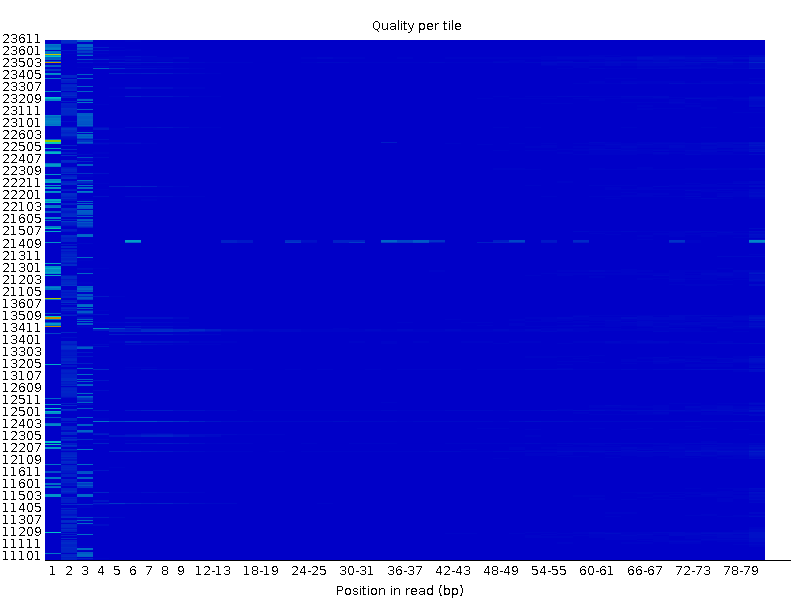

**Per sequence quality scores : pass**

**Per base sequence content : fail**

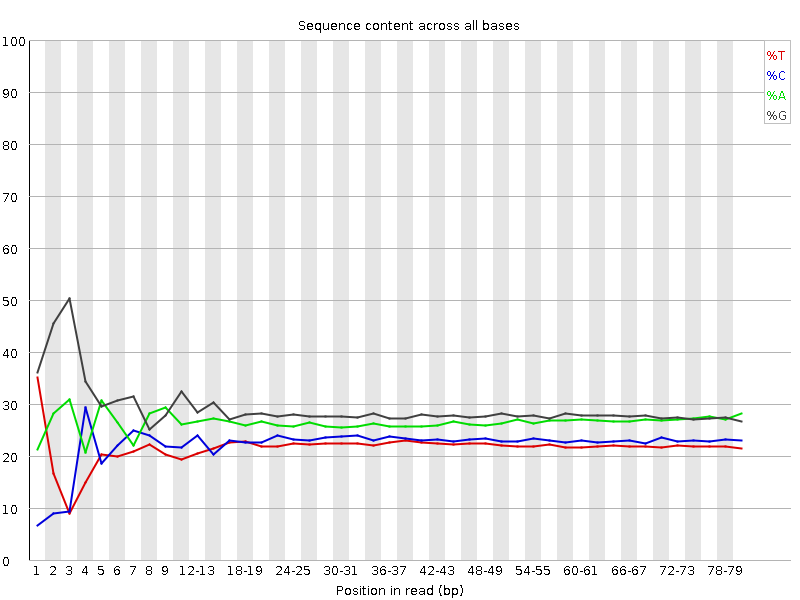

**Per sequence GC content : warn**

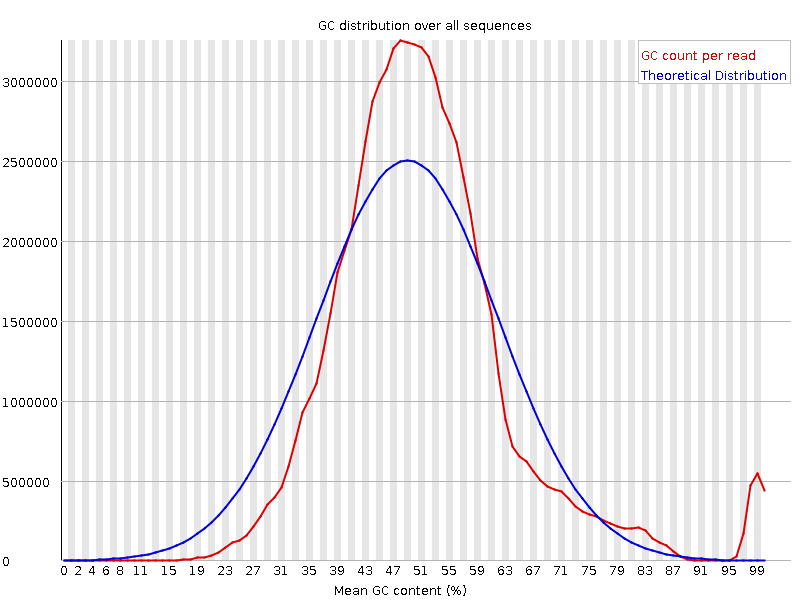

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : warn**

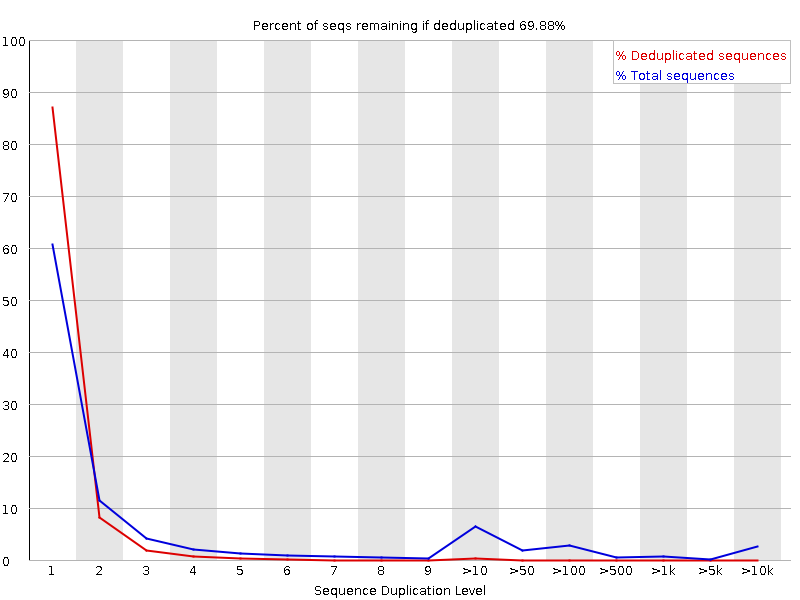

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,442472,0.6789365814691828,No Hit
TGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,329036,0.5048784488516653,No Hit
GTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,213383,0.32741851363168434,No Hit
TTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,183675,0.2818340518752648,No Hit
GGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,103655,0.15904999943993778,No Hit
GGGGTCTACGGCCATACCACCCTGAACGCGCCCGATCTCGTCTGATCTCG,90148,0.1383246283296658,No Hit
TGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,76024,0.11665252189881656,No Hit


**Adapter Content : warn**

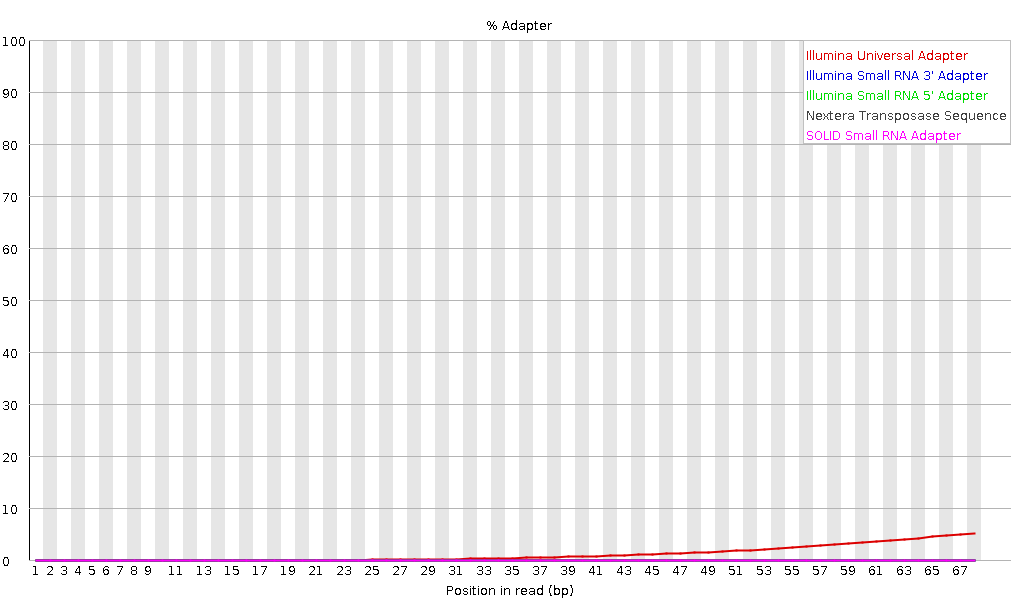

**Kmer Content : fail**

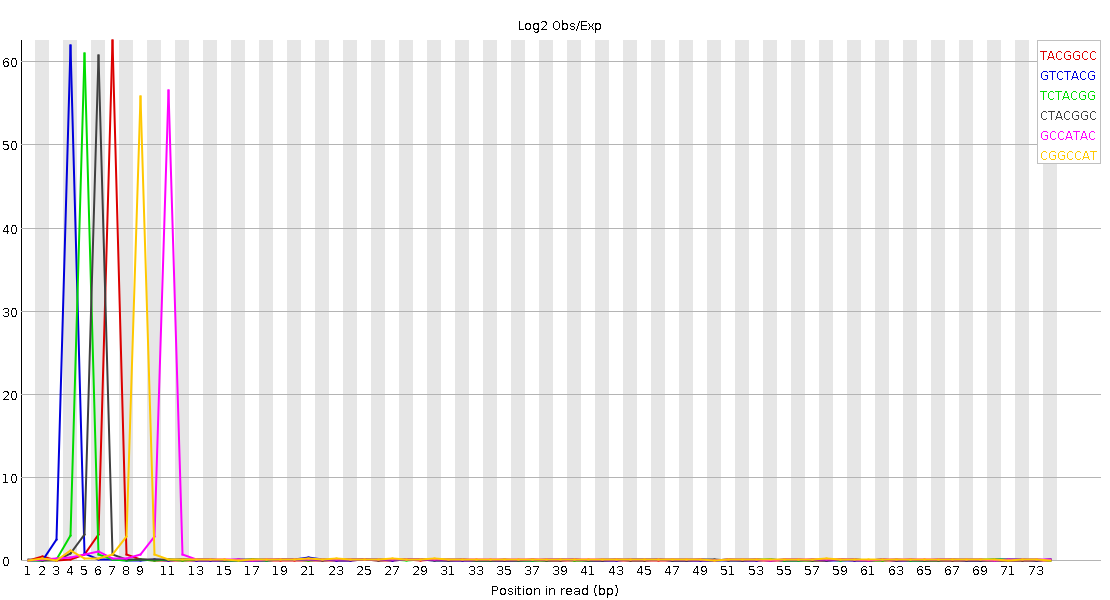

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
TACGGCC,64535,0.0,62.493473,7
GTCTACG,64935,0.0,61.97904,4
TCTACGG,66140,0.0,60.967316,5
CTACGGC,66405,0.0,60.768726,6
GCCATAC,70115,0.0,56.532173,11
CGGCCAT,72340,0.0,55.831947,9
AACGCGC,70610,0.0,55.51032,25
ACGGCCA,73300,0.0,55.17151,8
ACGCGCC,71835,0.0,54.55855,26
GGCCATA,74470,0.0,54.274776,10


---
## 41IIR_2_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,41IIR_2.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,67864299
Sequences flagged as poor quality,0
Sequence length,80
%GC,50


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

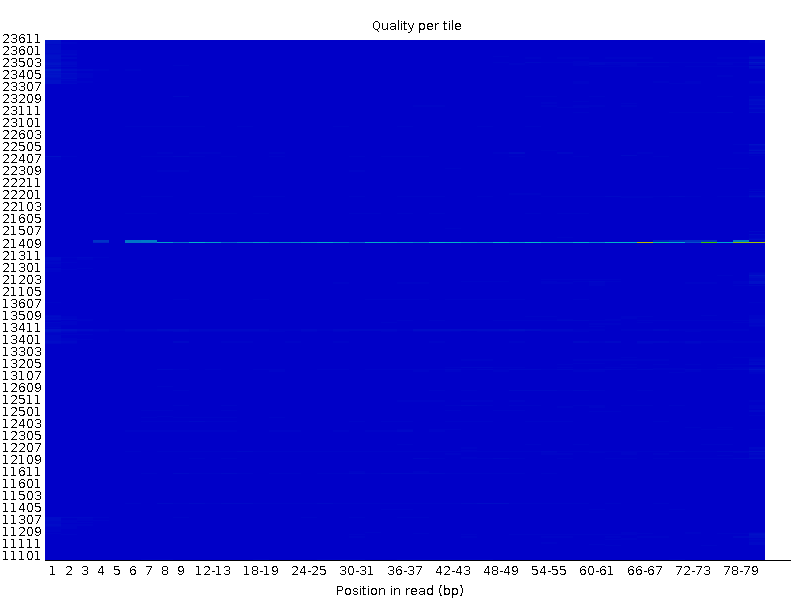

**Per sequence quality scores : pass**

**Per base sequence content : fail**

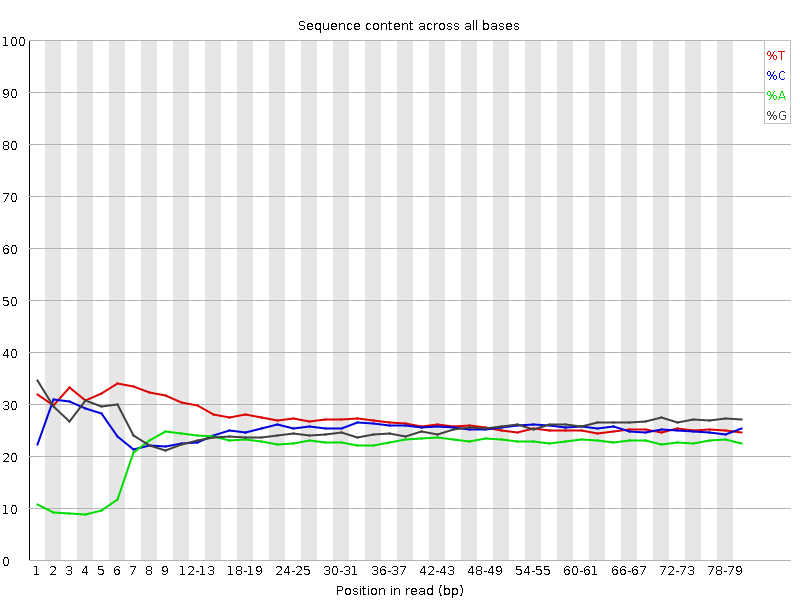

**Per sequence GC content : warn**

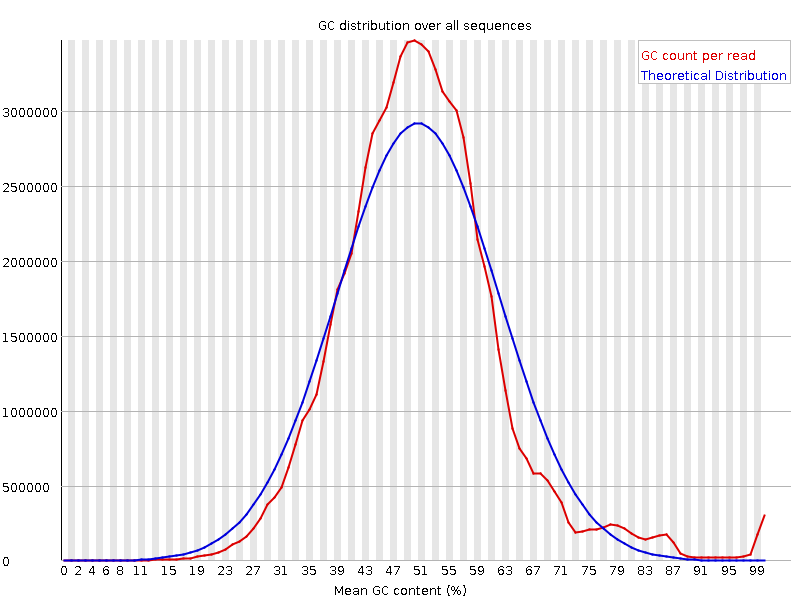

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

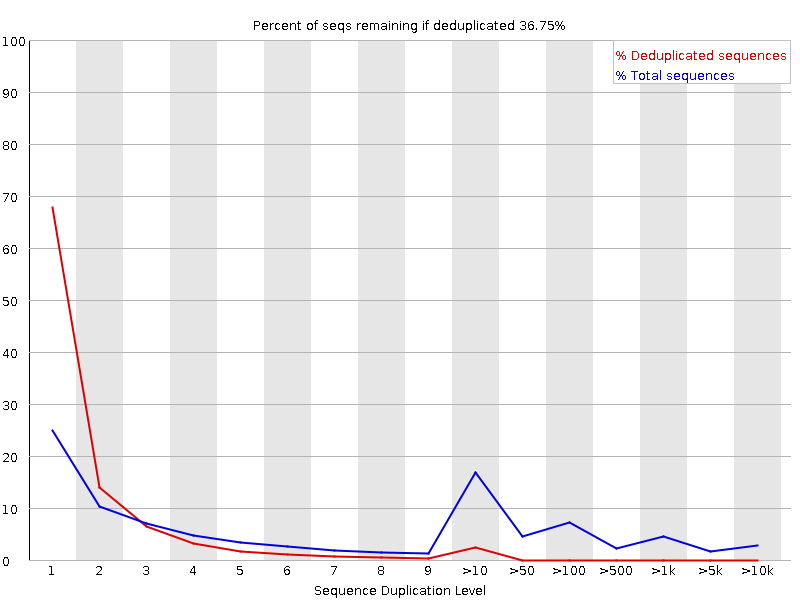

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,278538,0.4104337687183654,No Hit
TCCTCTAGATAGTCAAGTTCGACCGTCTTCTCAGCGCTCCGCCAGGGCCG,122418,0.18038645031904035,No Hit


**Adapter Content : warn**

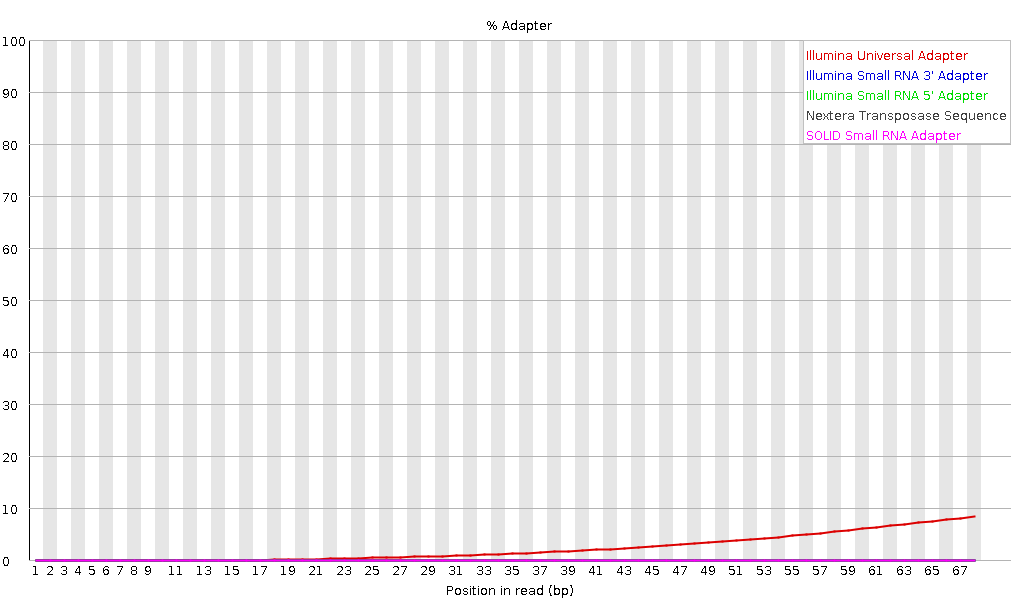

**Kmer Content : fail**

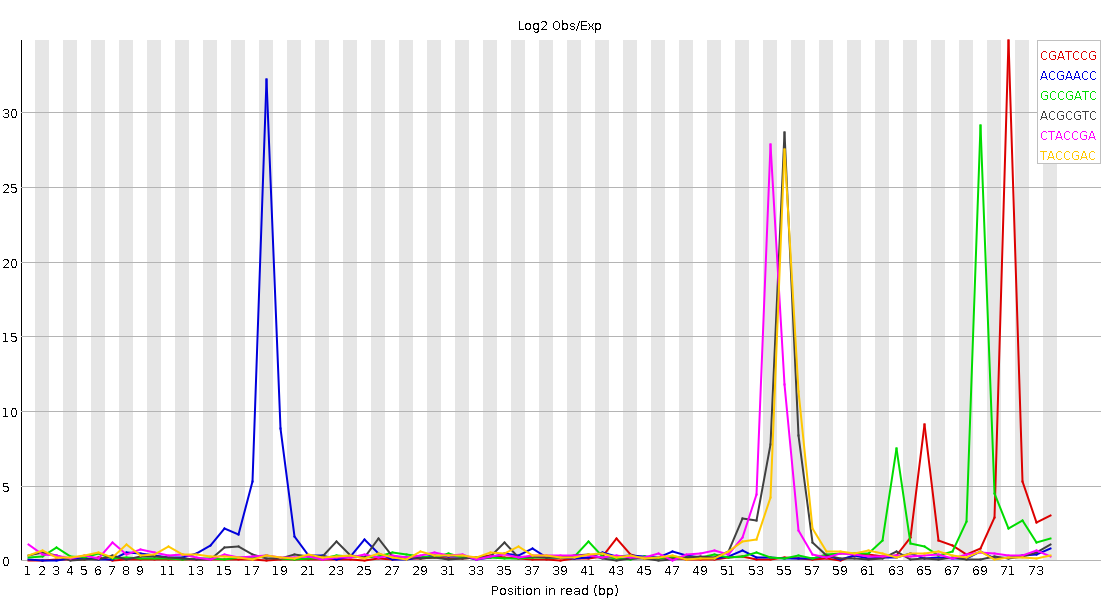

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
CGATCCG,30095,0.0,34.80224,71
ACGAACC,20740,0.0,32.199707,18
GCCGATC,38985,0.0,29.168959,69
ACGCGTC,16815,0.0,28.69982,55
CTACCGA,8785,0.0,27.887869,54
TACCGAC,8565,0.0,27.523933,55
TCCGAGG,40275,0.0,27.424494,74
CCGATCC,41260,0.0,27.292,70
AACGAAT,19645,0.0,26.805176,62
TCGACCG,51560,0.0,26.077005,19


---
## 42IIR_2_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,42IIR_2.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,57954458
Sequences flagged as poor quality,0
Sequence length,80
%GC,50


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

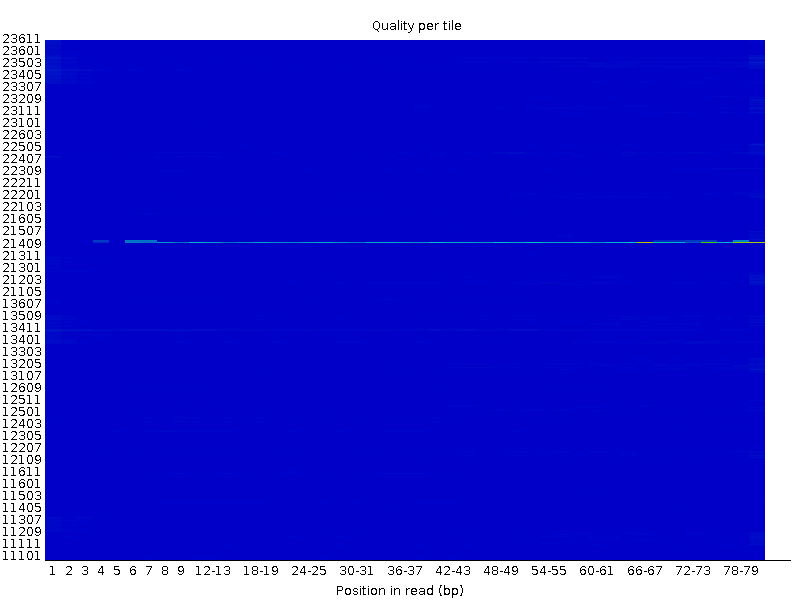

**Per sequence quality scores : pass**

**Per base sequence content : fail**

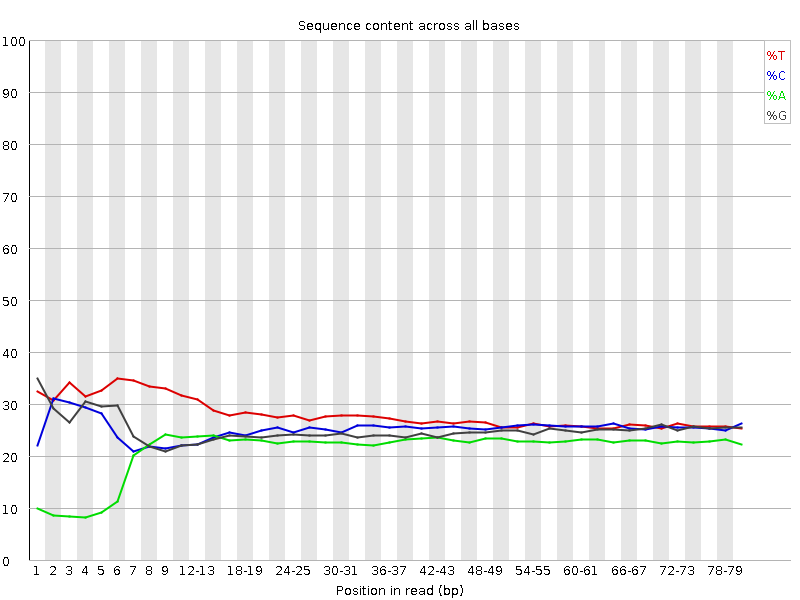

**Per sequence GC content : warn**

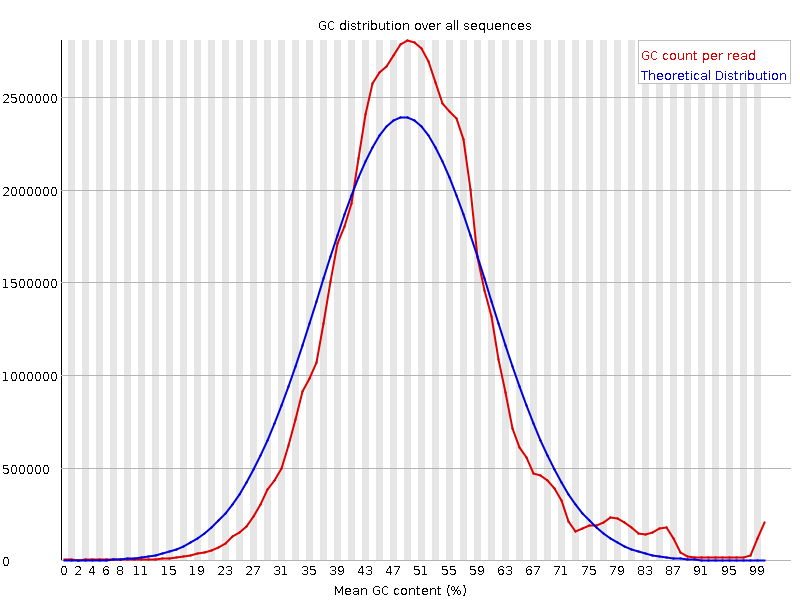

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

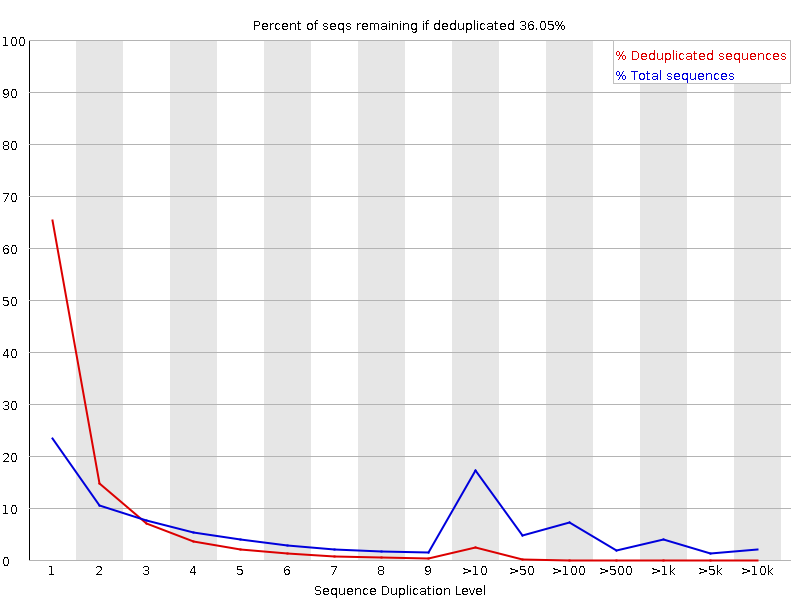

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,189307,0.32664786546705343,No Hit
GCTACGTACGAAACCCCGACCCAGAAGCAGGTCGTCTACGAATGGTTTAG,61512,0.1061385131062739,No Hit


**Adapter Content : pass**

**Kmer Content : fail**

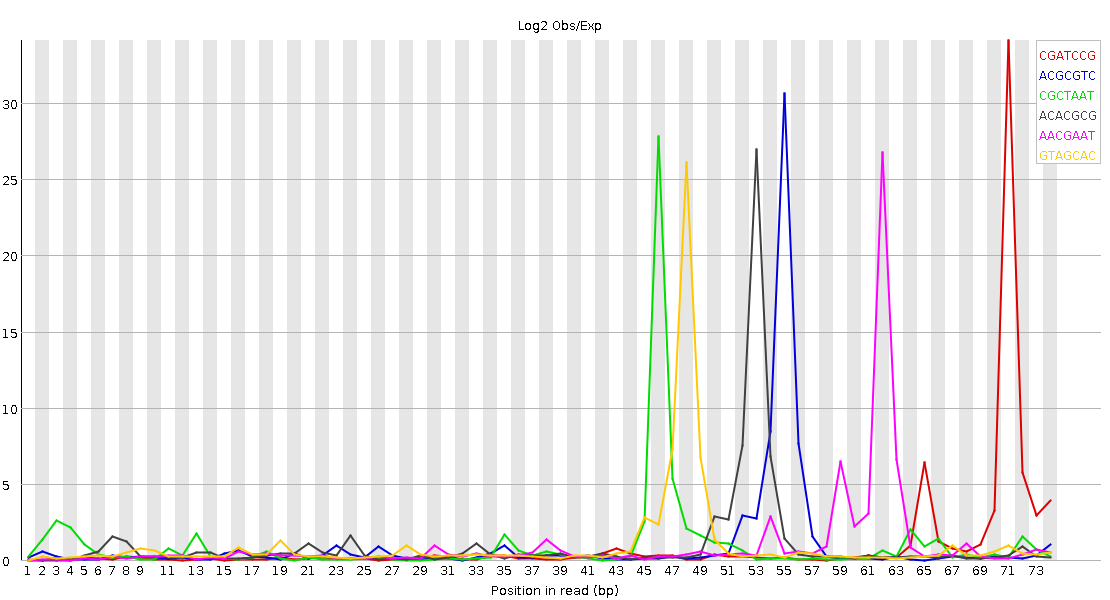

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
CGATCCG,14960,0.0,34.090527,71
ACGCGTC,15720,0.0,30.628138,55
CGCTAAT,16940,0.0,27.808687,46
ACACGCG,18315,0.0,26.975636,53
AACGAAT,15465,0.0,26.800106,62
GTAGCAC,53715,0.0,26.104103,48
AACAACG,29240,0.0,26.047144,59
ACAACGA,16620,0.0,25.873837,60
CAACGAA,16300,0.0,25.813793,61
GCCGATC,21285,0.0,25.799889,69


---
## 27IIR_2_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,27IIR_2.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,59095688
Sequences flagged as poor quality,0
Sequence length,80
%GC,50


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

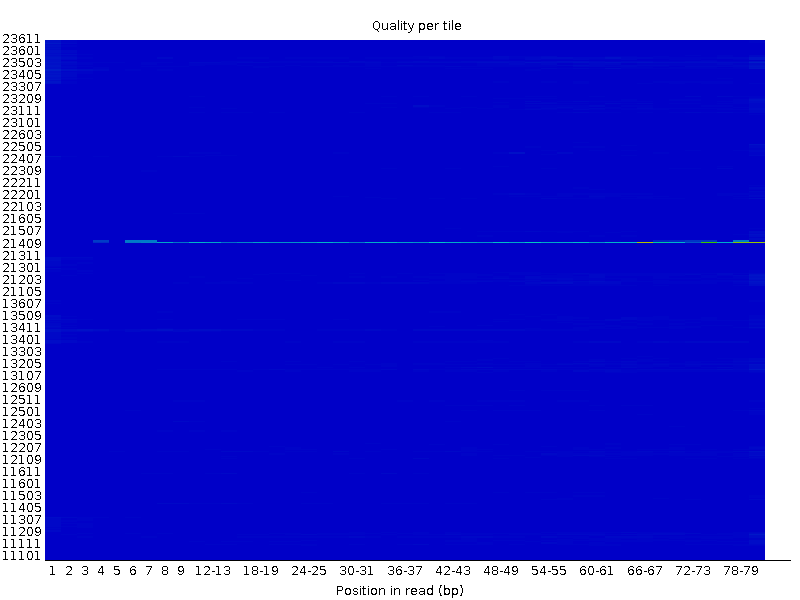

**Per sequence quality scores : pass**

**Per base sequence content : fail**

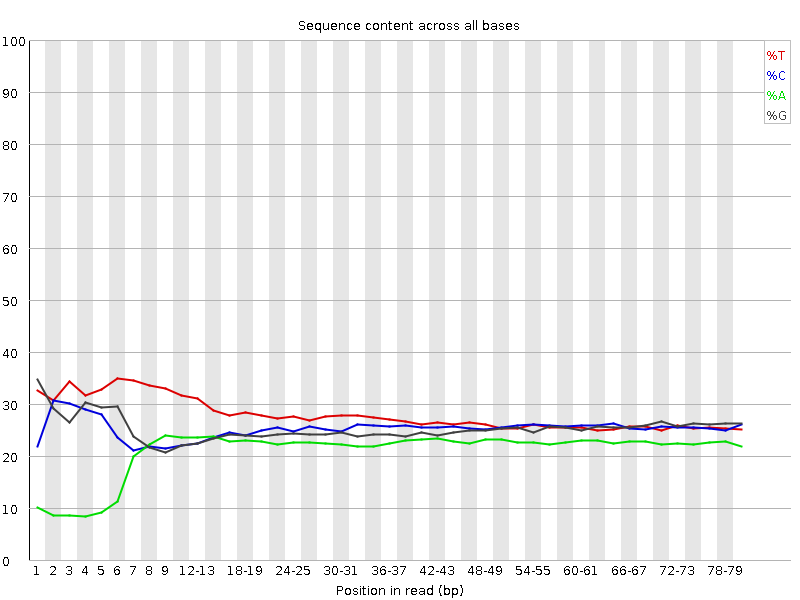

**Per sequence GC content : warn**

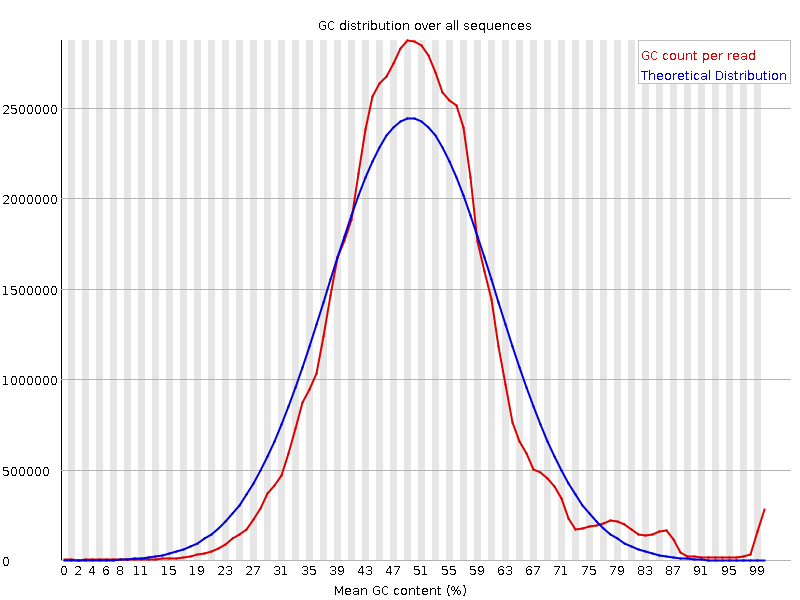

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

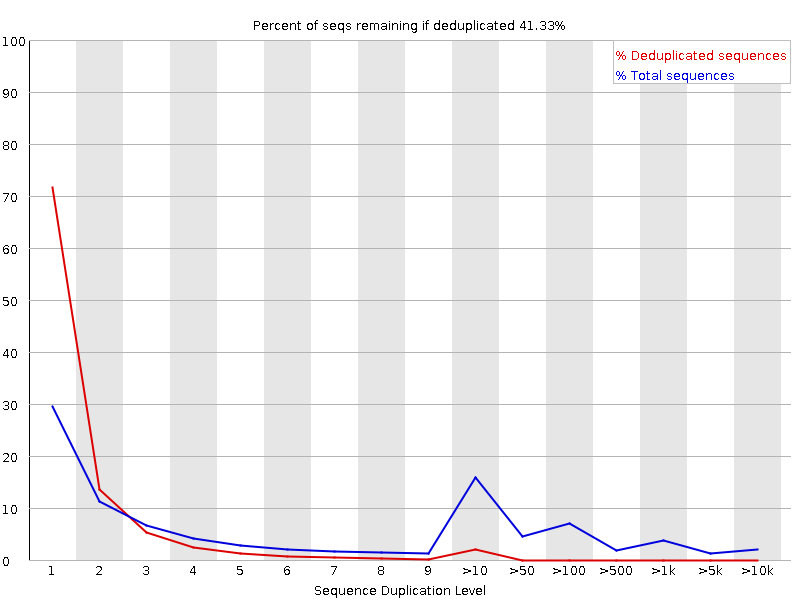

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,257029,0.4349369788198421,No Hit
TCCTCTAGATAGTCAAGTTCGACCGTCTTCTCAGCGCTCCGCCAGGGCCG,69045,0.1168359356439001,No Hit
GCTACGTACGAAACCCCGACCCAGAAGCAGGTCGTCTACGAATGGTTTAG,64957,0.10991834125021101,No Hit


**Adapter Content : pass**

**Kmer Content : fail**

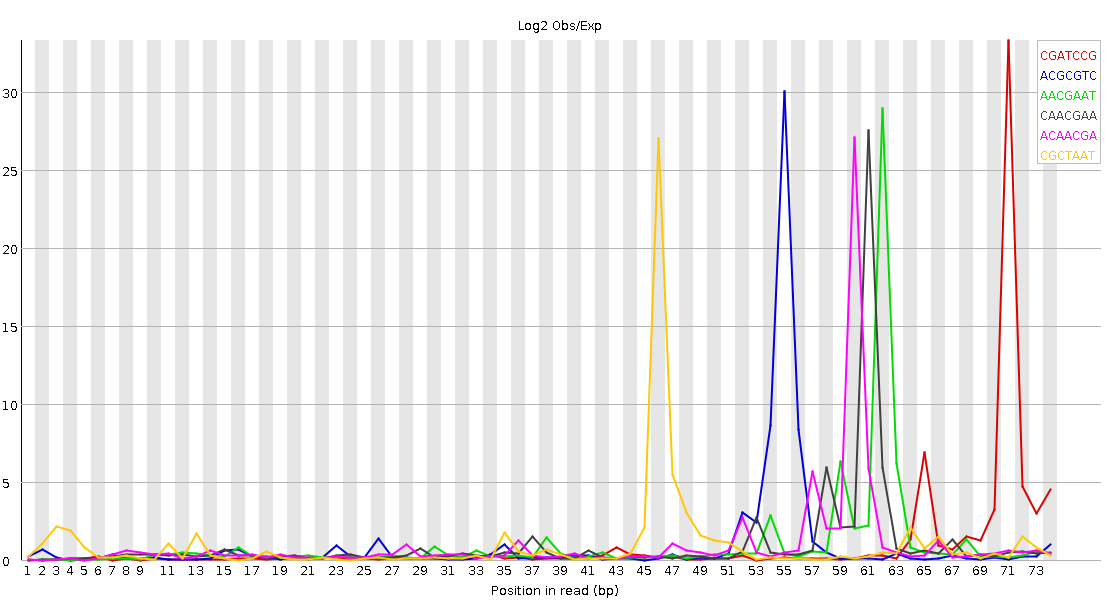

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
CGATCCG,19345,0.0,33.28865,71
ACGCGTC,17495,0.0,30.080072,55
AACGAAT,16305,0.0,28.937052,62
CAACGAA,17350,0.0,27.53628,61
ACAACGA,17870,0.0,27.108057,60
CGCTAAT,17865,0.0,27.05224,46
ACACGCG,19910,0.0,26.93353,53
GCCGATC,24825,0.0,26.607536,69
CGCCCTA,9550,0.0,26.311459,61
AACAACG,31260,0.0,25.90285,59


---
## 32IIR_1_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,32IIR_1.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,66748506
Sequences flagged as poor quality,0
Sequence length,80
%GC,52


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

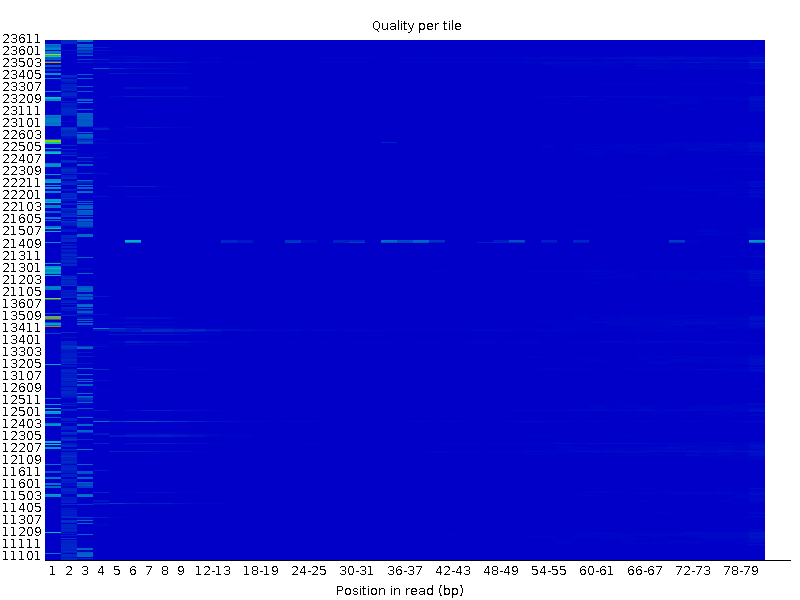

**Per sequence quality scores : pass**

**Per base sequence content : fail**

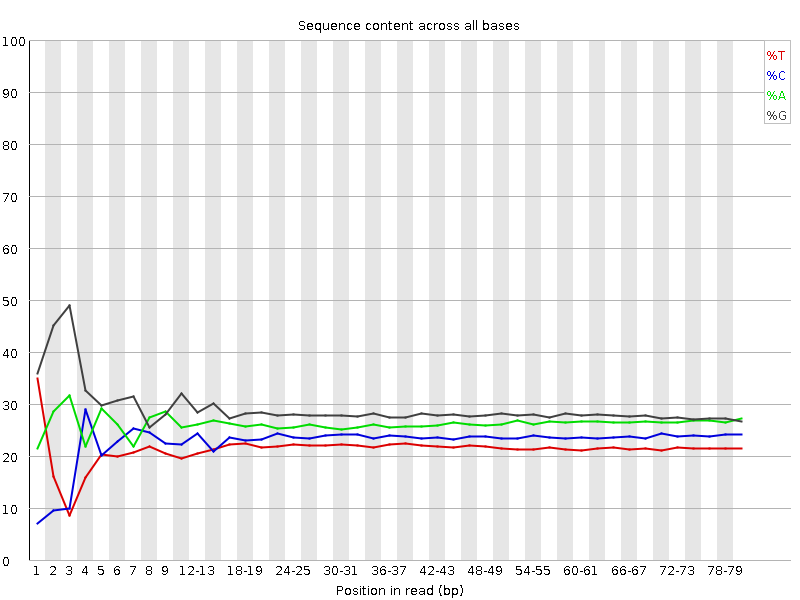

**Per sequence GC content : warn**

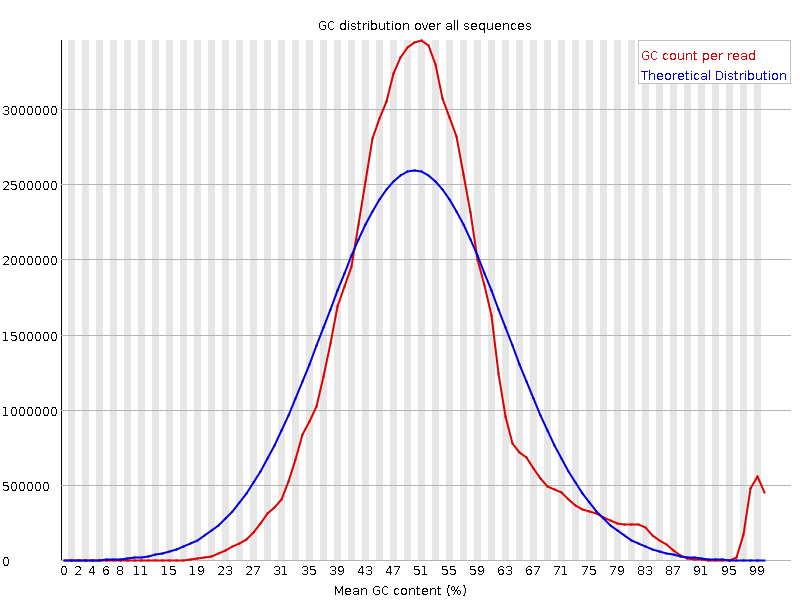

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : warn**

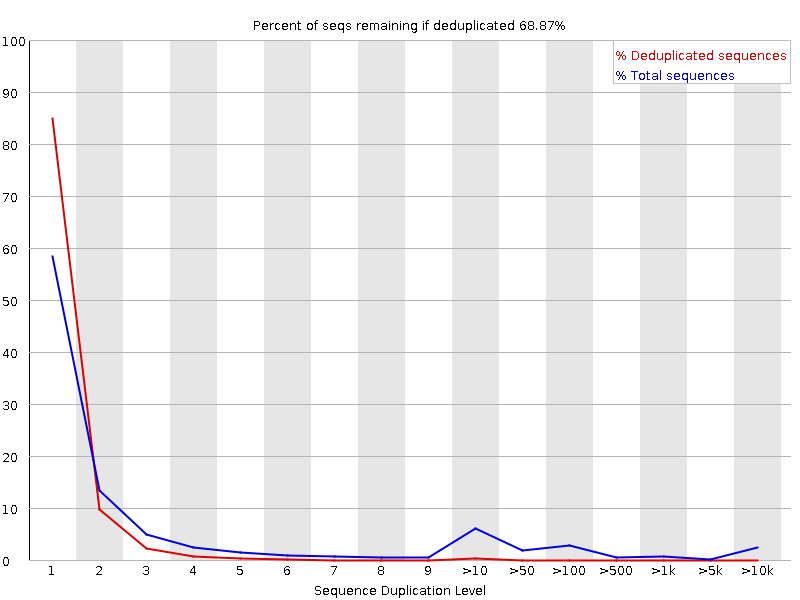

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,454071,0.6802714056251686,No Hit
TGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,335402,0.50248615302341,No Hit
GTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,211932,0.3175082300718461,No Hit
TTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,185433,0.2778084651063201,No Hit
GGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,105006,0.15731588059813653,No Hit
GGGGTCTACGGCCATACCACCCTGAACGCGCCCGATCTCGTCTGATCTCG,78375,0.11741835839741491,No Hit
TGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,77875,0.11666927796106777,No Hit


**Adapter Content : warn**

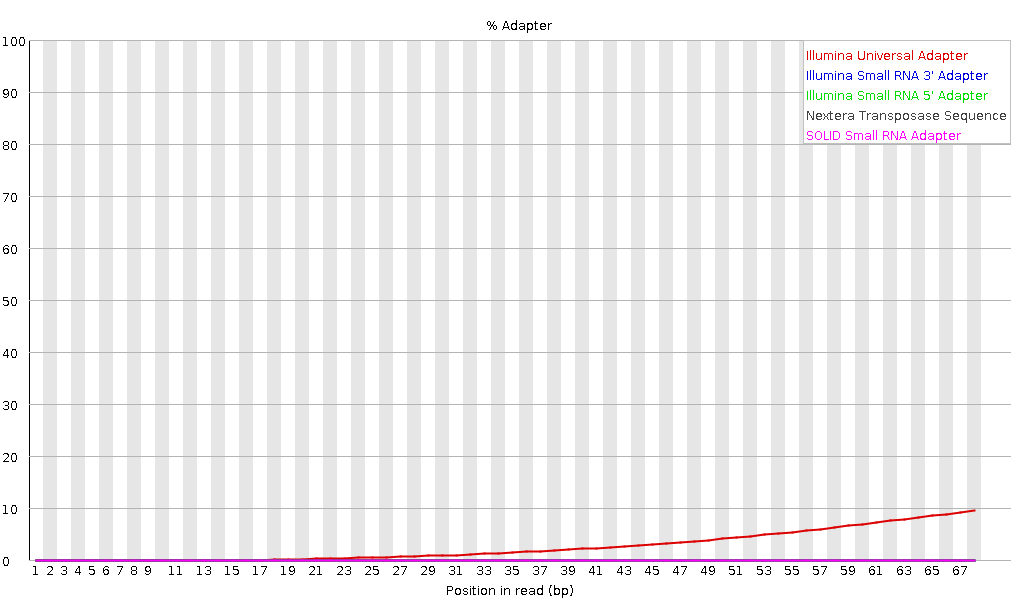

**Kmer Content : fail**

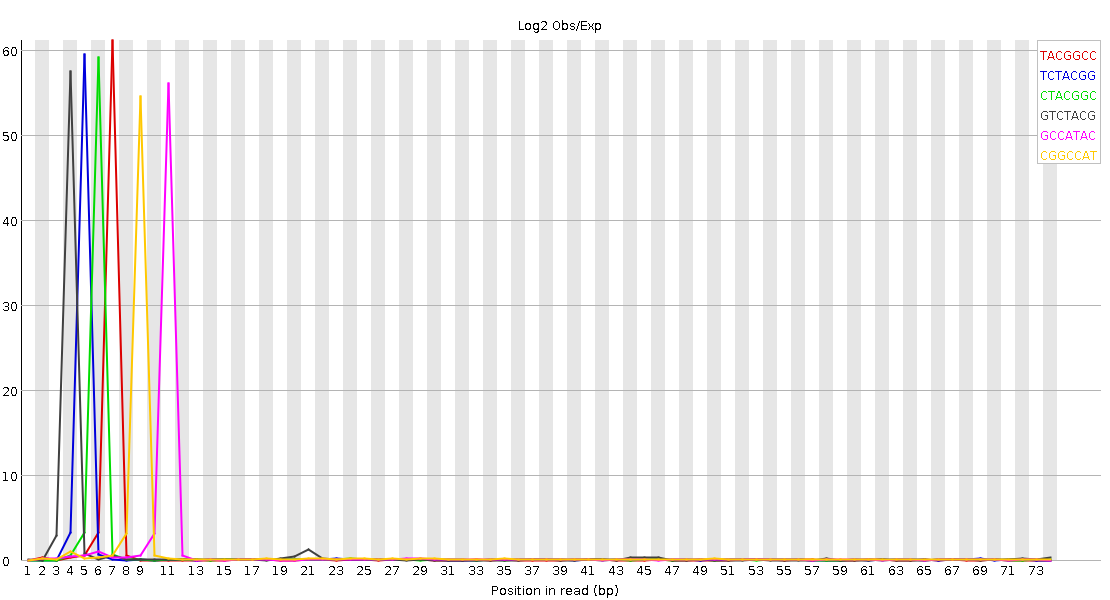

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
TACGGCC,61715,0.0,61.086914,7
TCTACGG,63215,0.0,59.544983,5
CTACGGC,63675,0.0,59.16143,6
GTCTACG,65700,0.0,57.45046,4
GCCATAC,66425,0.0,56.08647,11
CGGCCAT,69175,0.0,54.530838,9
AACGCGC,67765,0.0,53.757008,25
GGCCATA,71010,0.0,53.21542,10
ACGGCCA,71145,0.0,53.07284,8
ACGCGCC,68980,0.0,52.78332,26


---
## 27IIR_1_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,27IIR_1.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,59095688
Sequences flagged as poor quality,0
Sequence length,80
%GC,52


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

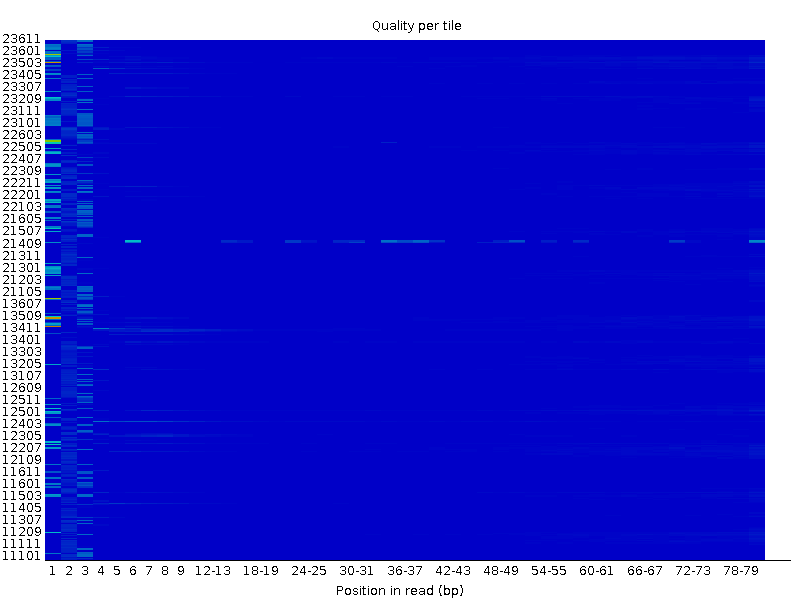

**Per sequence quality scores : pass**

**Per base sequence content : fail**

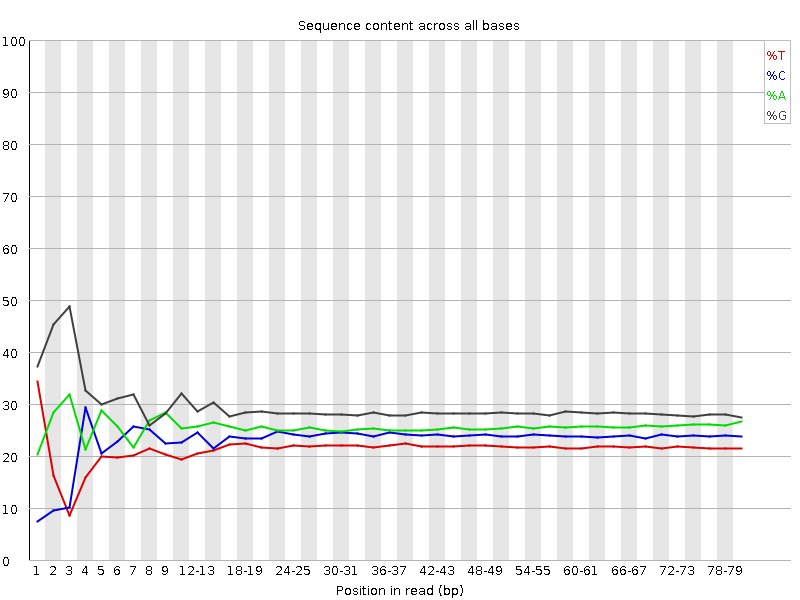

**Per sequence GC content : warn**

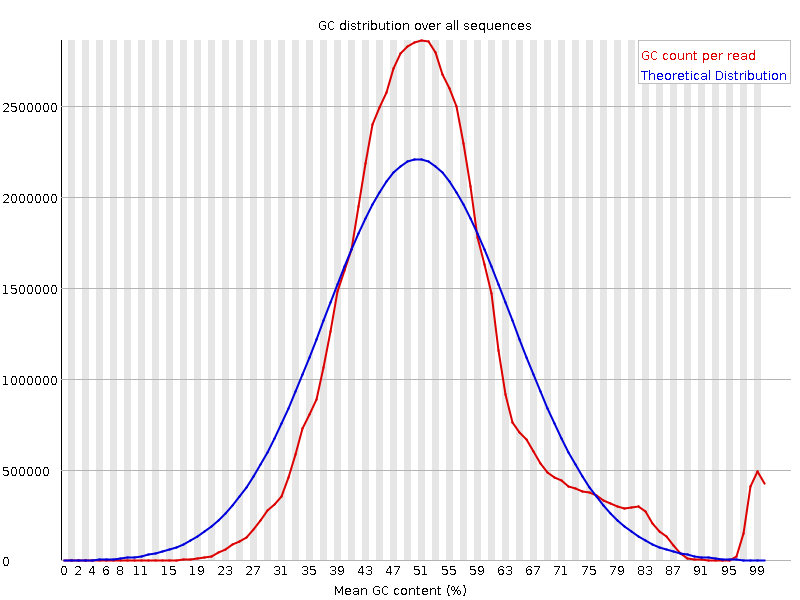

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : pass**

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,426110,0.721050916608332,No Hit
TGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,273662,0.46308285640062263,No Hit
GTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,186329,0.3153005004358355,No Hit
TTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,163580,0.27680530599796044,No Hit
GGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,95126,0.16096944332046698,No Hit
TGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,65827,0.11139052988096186,No Hit


**Adapter Content : pass**

**Kmer Content : fail**

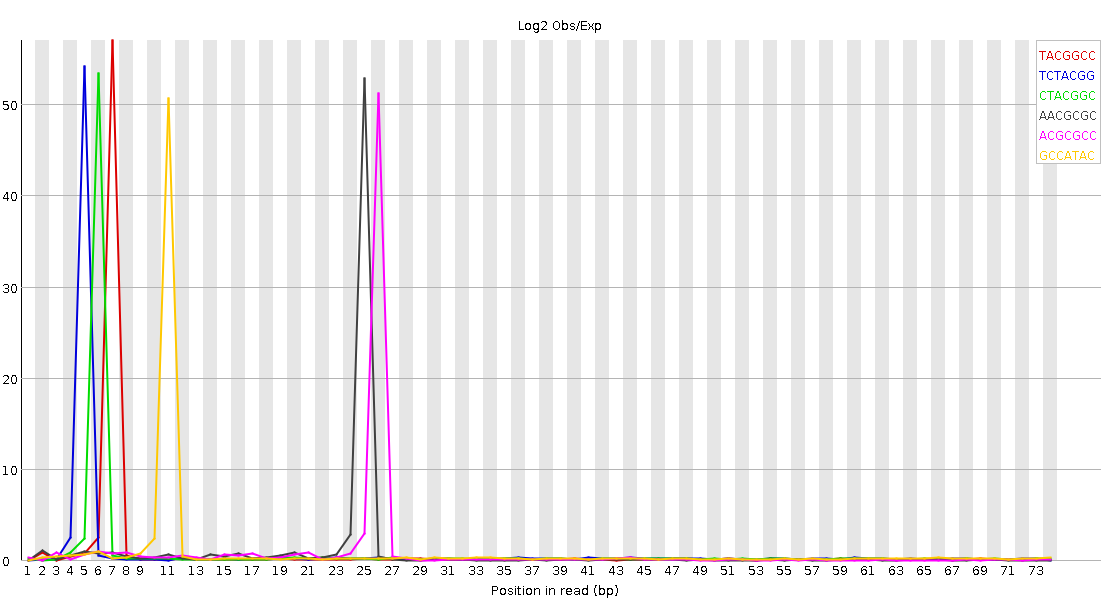

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
TACGGCC,35025,0.0,56.955357,7
TCTACGG,36700,0.0,54.196022,5
CTACGGC,37410,0.0,53.41487,6
AACGCGC,36935,0.0,52.829914,25
ACGCGCC,38310,0.0,51.19462,26
GCCATAC,39010,0.0,50.662514,11
GAACGCG,39630,0.0,49.33959,24
GTCTACG,40715,0.0,49.169754,4
CGGCCAT,41645,0.0,48.11434,9
CCCGATC,40640,0.0,47.949963,31


---
## 26IIR_2_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,26IIR_2.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,65171330
Sequences flagged as poor quality,0
Sequence length,80
%GC,49


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

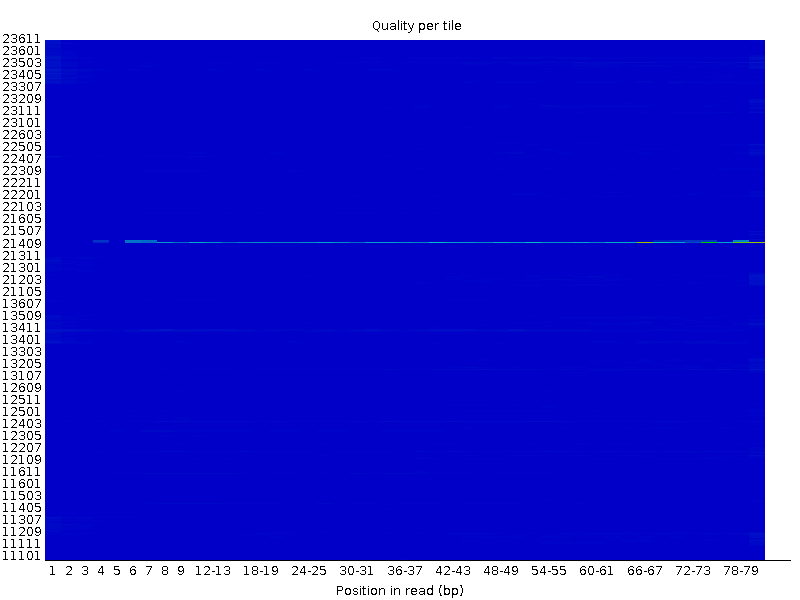

**Per sequence quality scores : pass**

**Per base sequence content : fail**

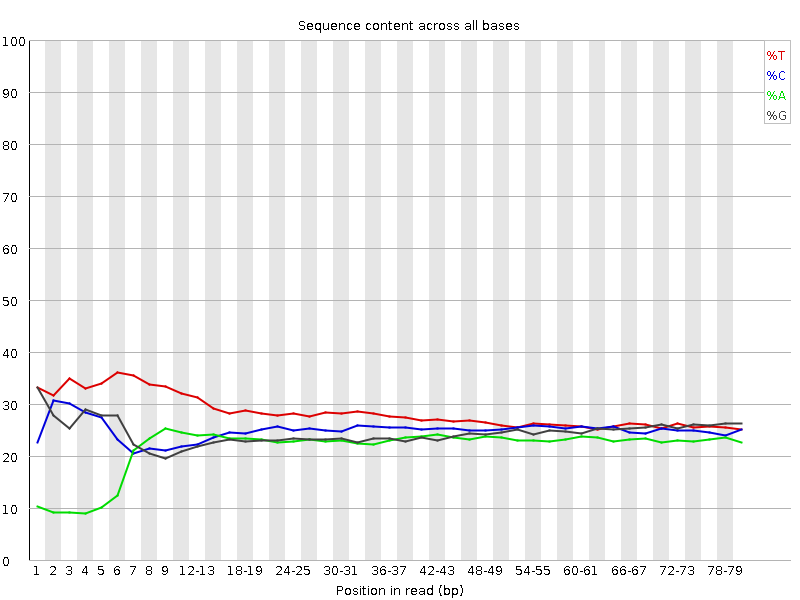

**Per sequence GC content : warn**

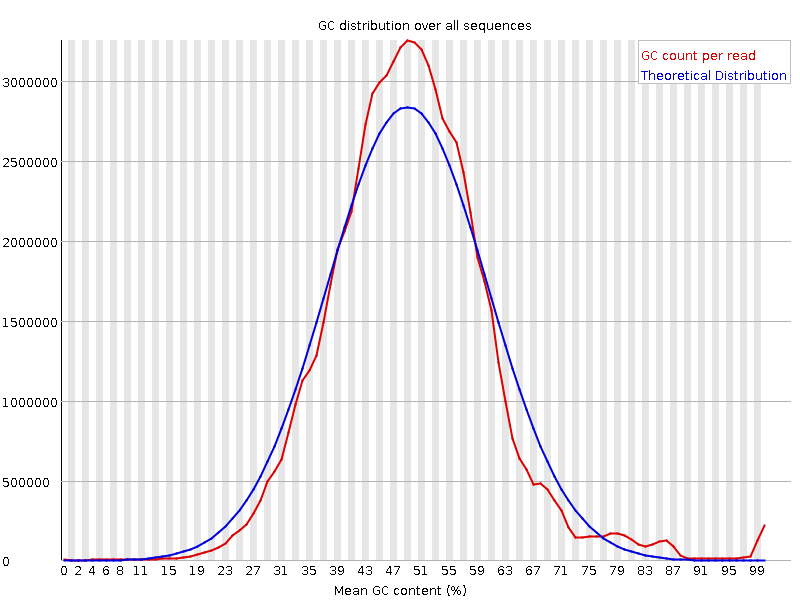

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

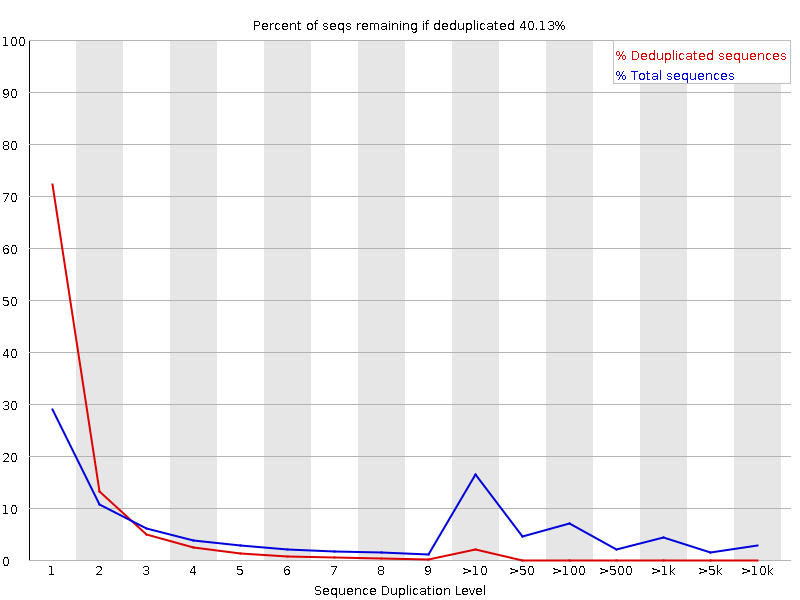

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,204314,0.3135028853945439,No Hit
TCCTCTAGATAGTCAAGTTCGACCGTCTTCTCAGCGCTCCGCCAGGGCCG,138139,0.21196283703278726,No Hit
GCTGGTACCAATTTGTCTTAGTCAGGGTTTCTATTCCTGCACAAACATCA,70745,0.10855233428564369,No Hit


**Adapter Content : warn**

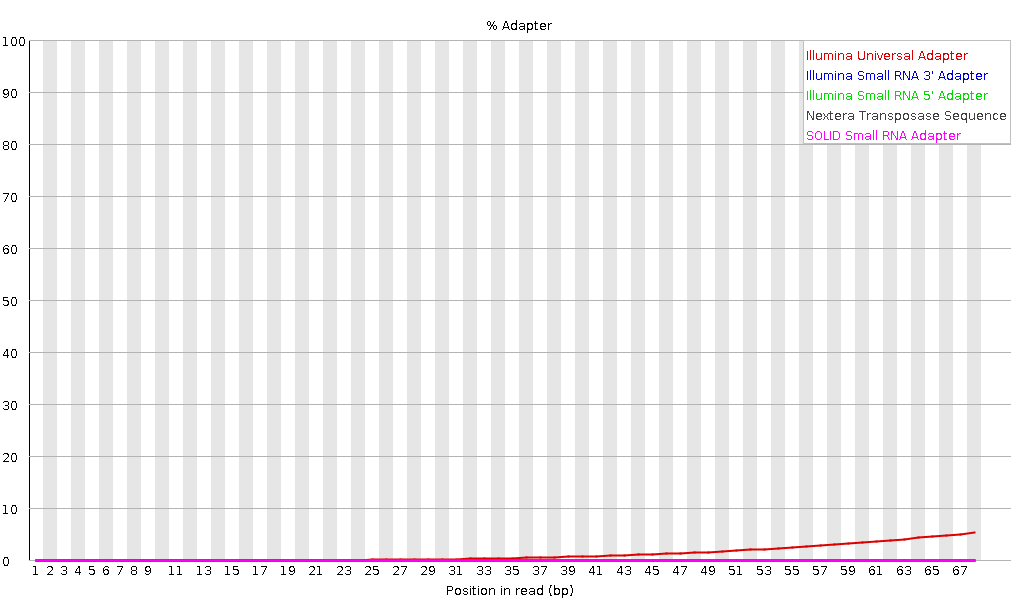

**Kmer Content : fail**

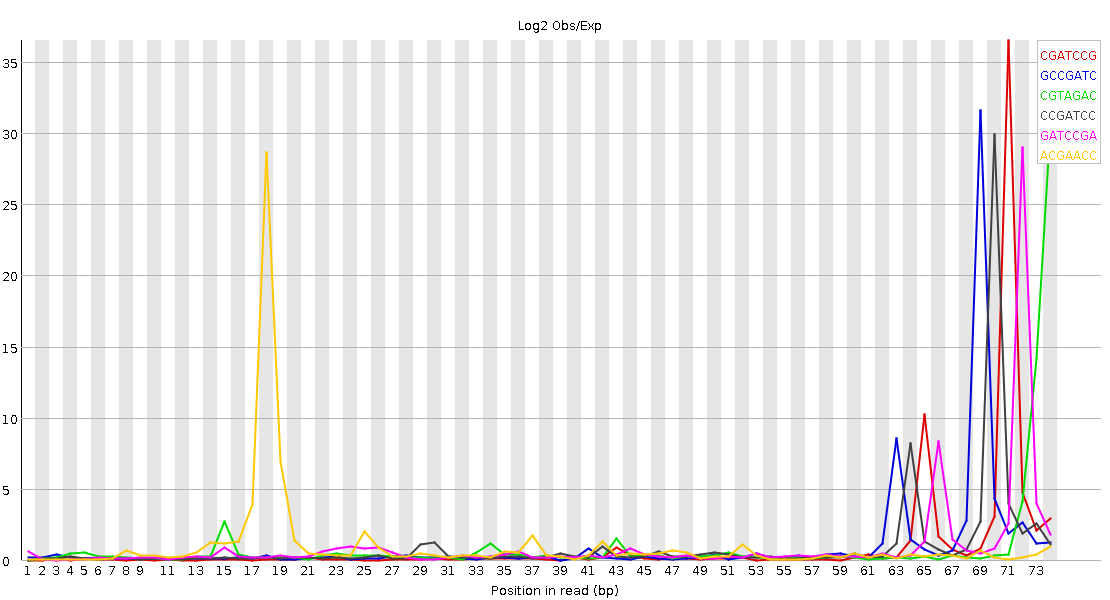

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
CGATCCG,31330,0.0,36.490246,71
GCCGATC,39300,0.0,31.618408,69
CGTAGAC,33240,0.0,30.601099,74
CCGATCC,41270,0.0,29.9214,70
GATCCGA,36770,0.0,29.030502,72
ACGAACC,15625,0.0,28.651003,18
TCCGAGG,40710,0.0,28.341118,74
CGCCCTA,10575,0.0,27.296385,61
TCGACCG,51295,0.0,27.29321,19
CGACCGT,50970,0.0,27.276876,20


---
## 41IIR_1_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,41IIR_1.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,67864299
Sequences flagged as poor quality,0
Sequence length,80
%GC,52


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

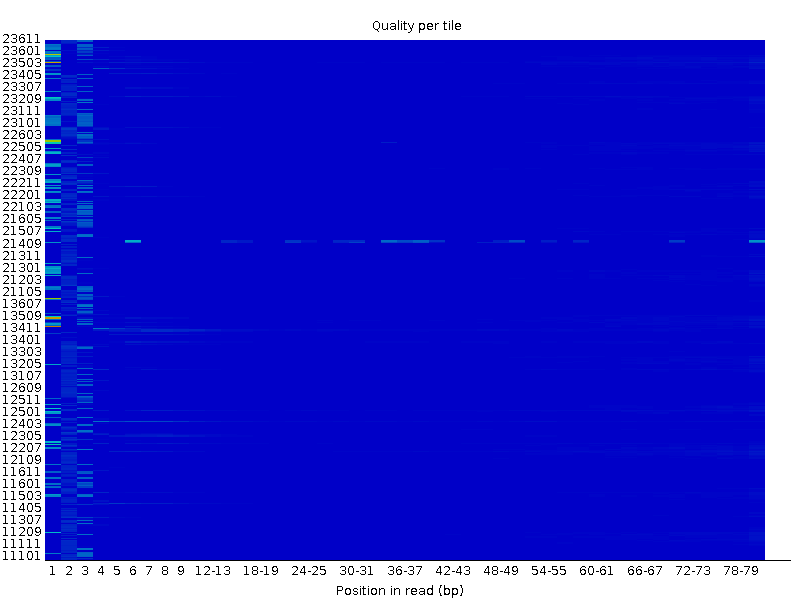

**Per sequence quality scores : pass**

**Per base sequence content : fail**

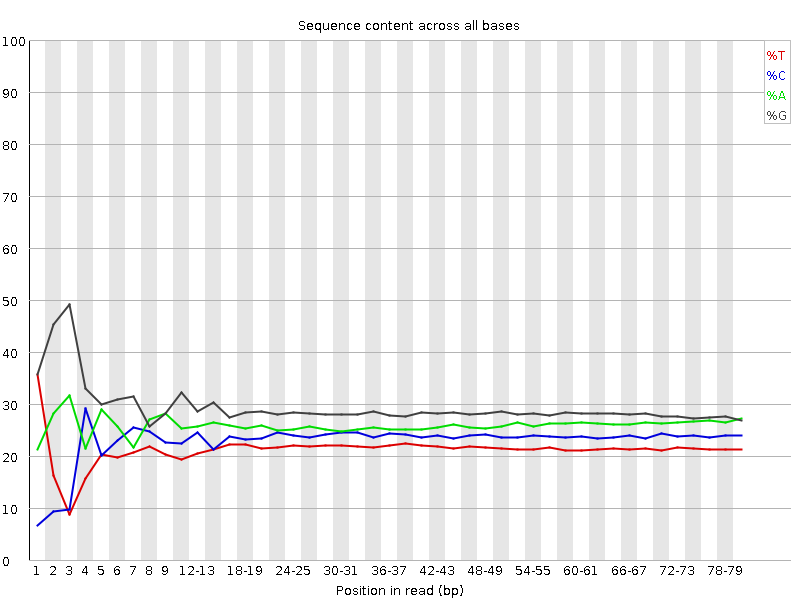

**Per sequence GC content : fail**

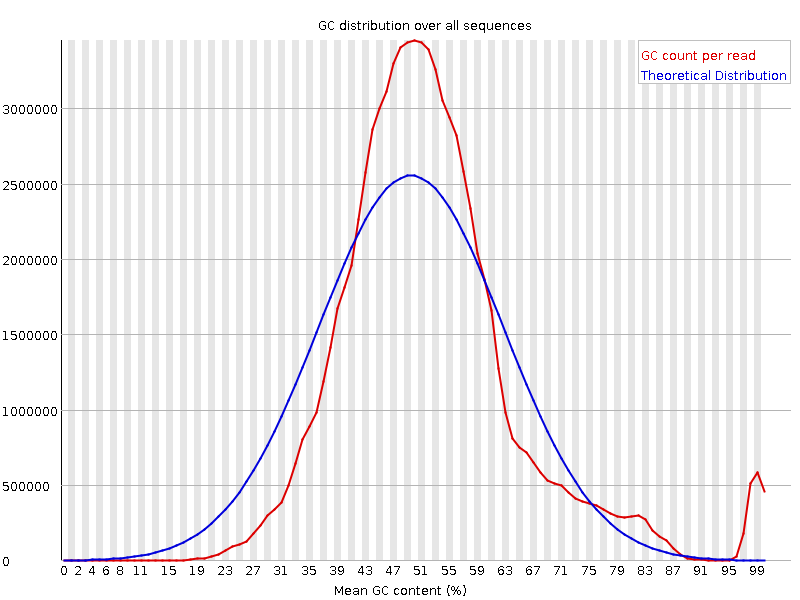

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : warn**

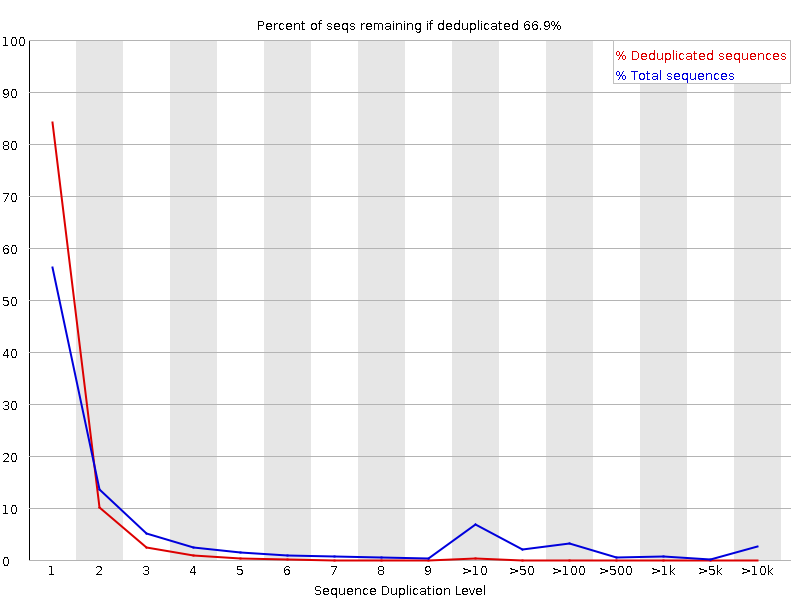

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,459187,0.6766252753896419,No Hit
TGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,358911,0.5288657000641824,No Hit
GTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,233636,0.3442693779243192,No Hit
TTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,192532,0.28370144956481463,No Hit
GGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,114800,0.1691611078160551,No Hit
TGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,83187,0.1225784414276496,No Hit
GGGGTCTACGGCCATACCACCCTGAACGCGCCCGATCTCGTCTGATCTCG,76334,0.1124803484671668,No Hit


**Adapter Content : warn**

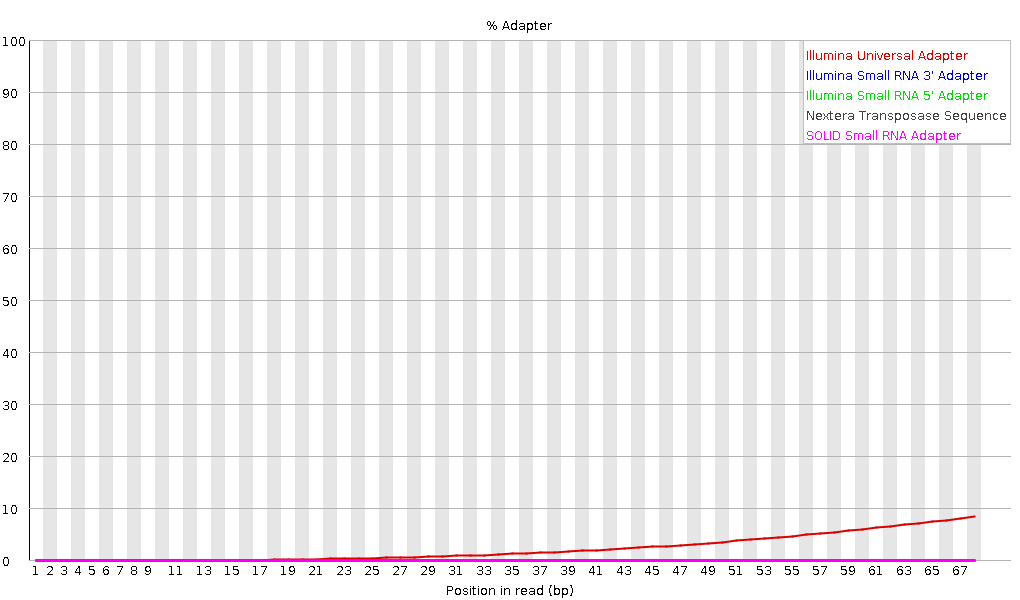

**Kmer Content : fail**

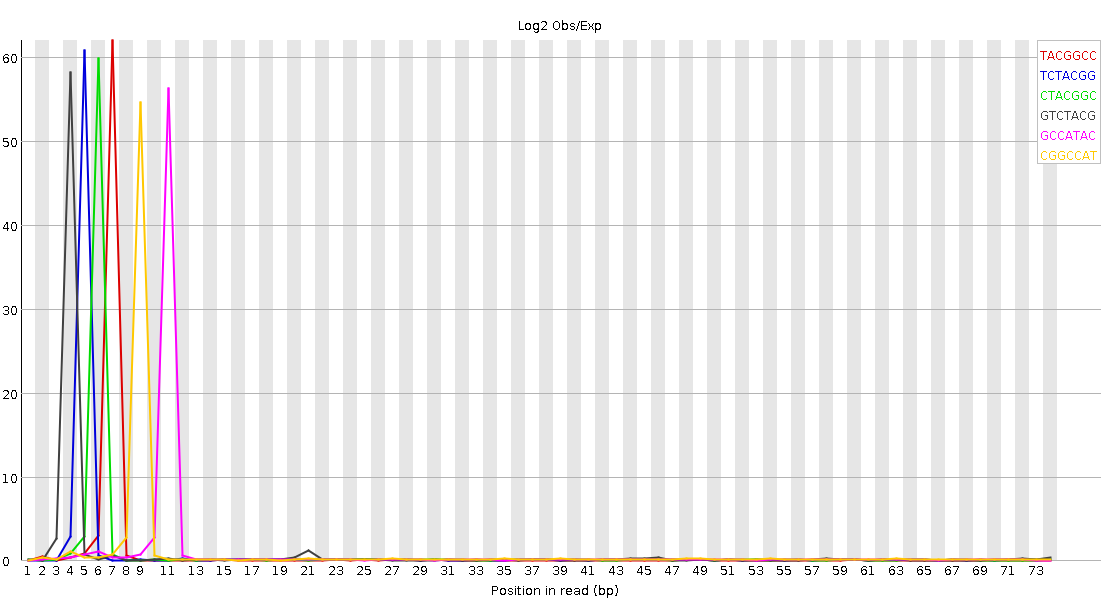

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
TACGGCC,63590,0.0,61.9851,7
TCTACGG,64670,0.0,60.91087,5
CTACGGC,65815,0.0,59.924446,6
GTCTACG,67780,0.0,58.19793,4
GCCATAC,69070,0.0,56.36988,11
CGGCCAT,72305,0.0,54.661823,9
AACGCGC,70375,0.0,54.19716,25
ACGGCCA,73565,0.0,53.791054,8
GGCCATA,73540,0.0,53.77911,10
ACGCGCC,71770,0.0,53.05617,26


---
## 32IIR_2_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,32IIR_2.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,66748506
Sequences flagged as poor quality,0
Sequence length,80
%GC,50


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

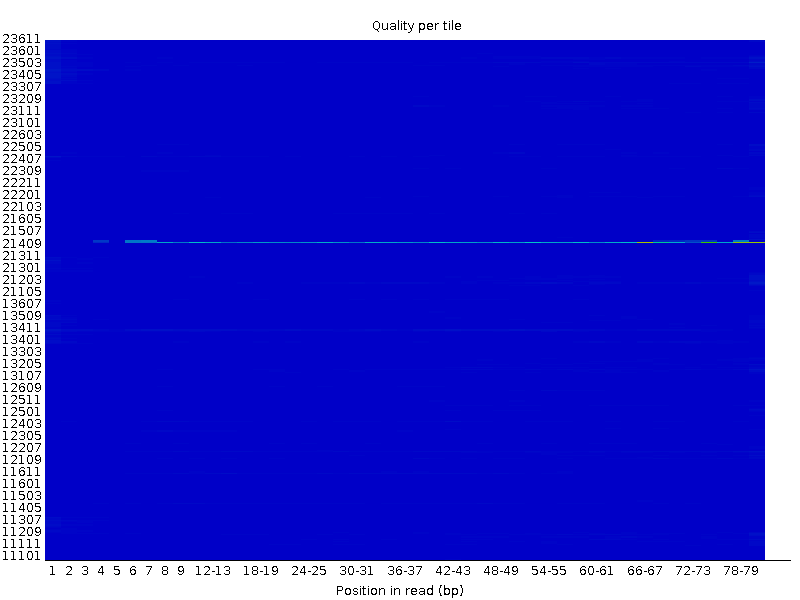

**Per sequence quality scores : pass**

**Per base sequence content : fail**

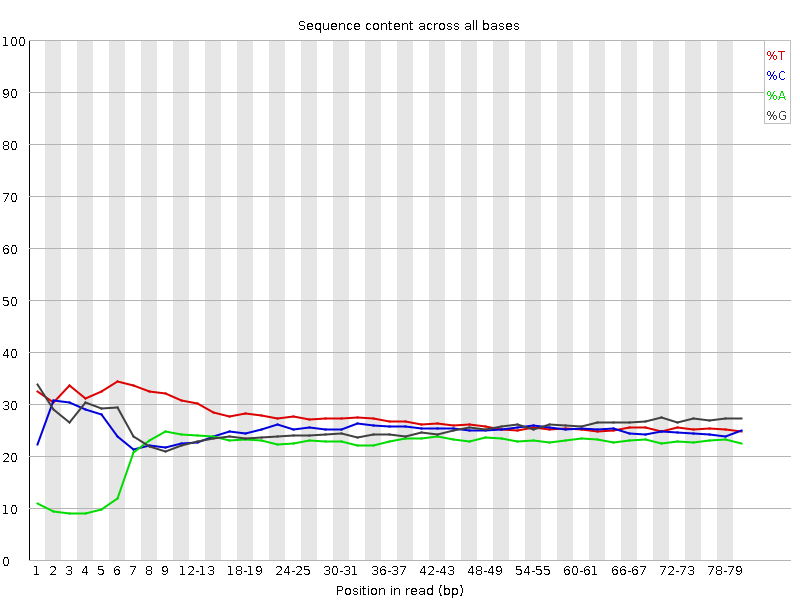

**Per sequence GC content : warn**

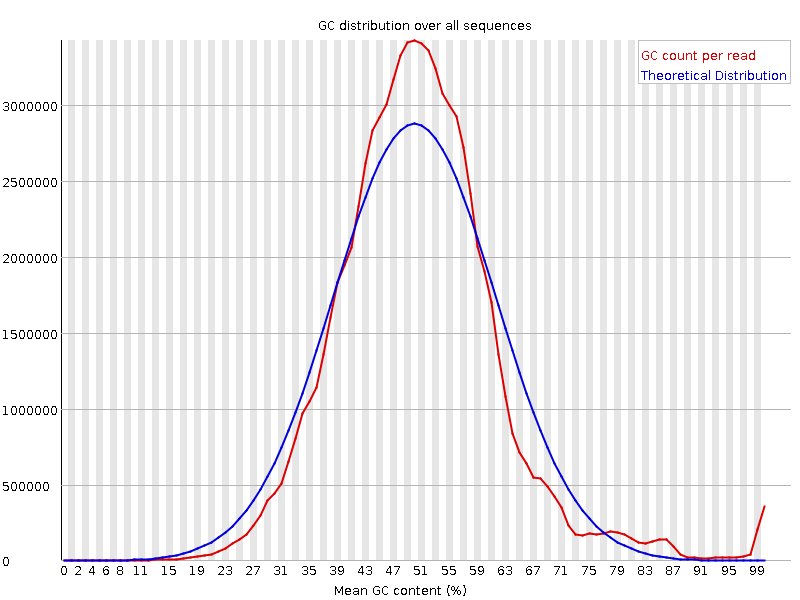

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

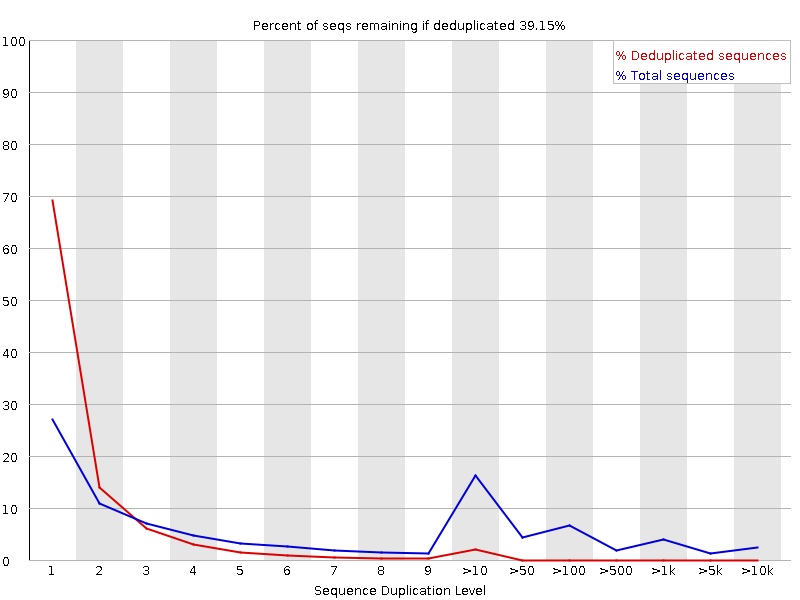

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,332544,0.4982044092492497,No Hit
TCCTCTAGATAGTCAAGTTCGACCGTCTTCTCAGCGCTCCGCCAGGGCCG,110748,0.16591832032914713,No Hit


**Adapter Content : warn**

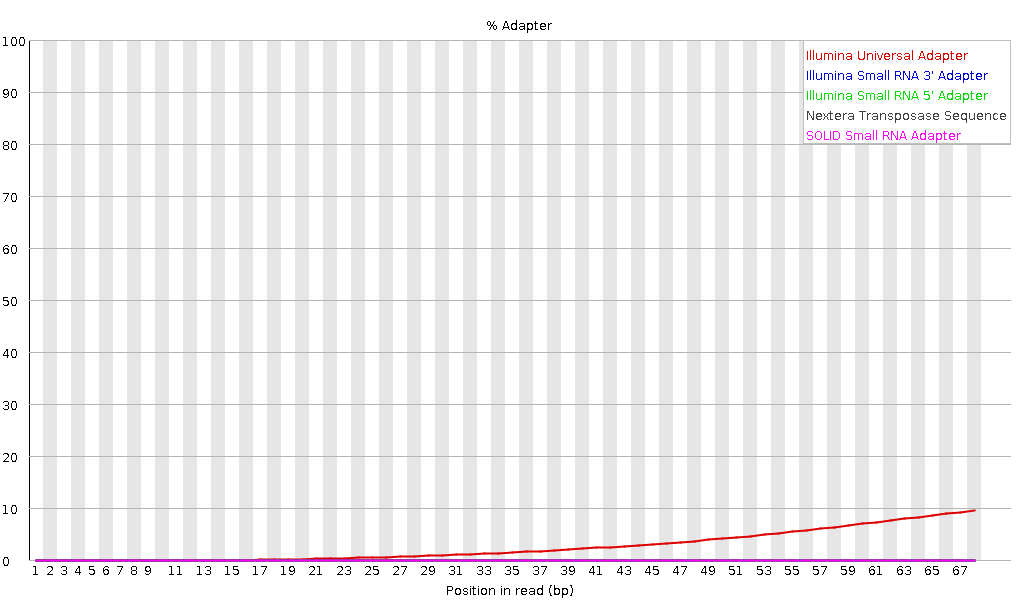

**Kmer Content : fail**

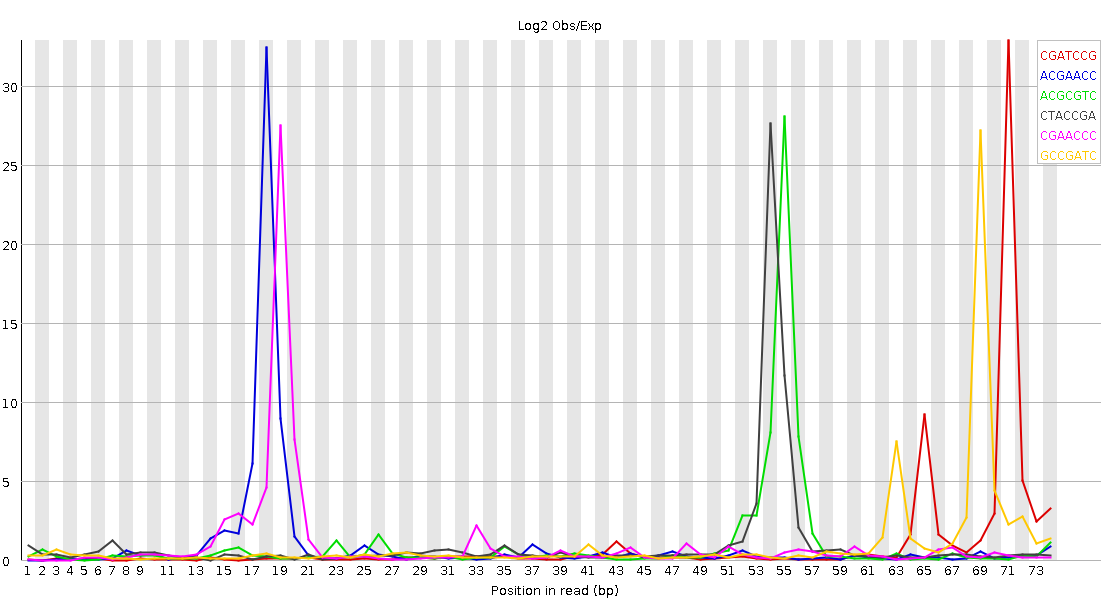

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
CGATCCG,27750,0.0,32.888294,71
ACGAACC,22475,0.0,32.479916,18
ACGCGTC,15760,0.0,28.108042,55
CTACCGA,9315,0.0,27.651793,54
CGAACCC,43885,0.0,27.543692,19
GCCGATC,36655,0.0,27.196709,69
TACCGAC,9050,0.0,27.152649,55
GAAACGA,11400,0.0,27.130533,15
TACGAAC,6485,0.0,26.813946,17
GATACGA,5570,0.0,26.767435,15


---
## 42IIR_1_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,42IIR_1.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,57954458
Sequences flagged as poor quality,0
Sequence length,80
%GC,52


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

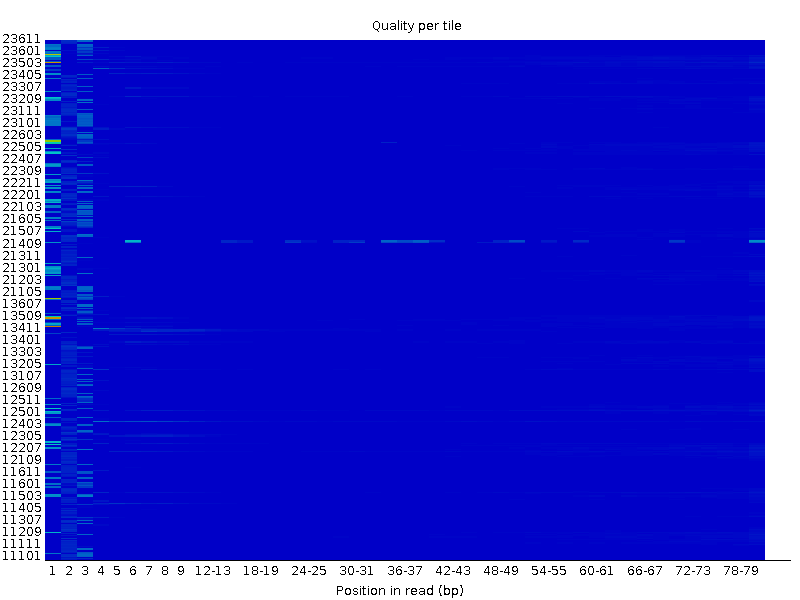

**Per sequence quality scores : pass**

**Per base sequence content : fail**

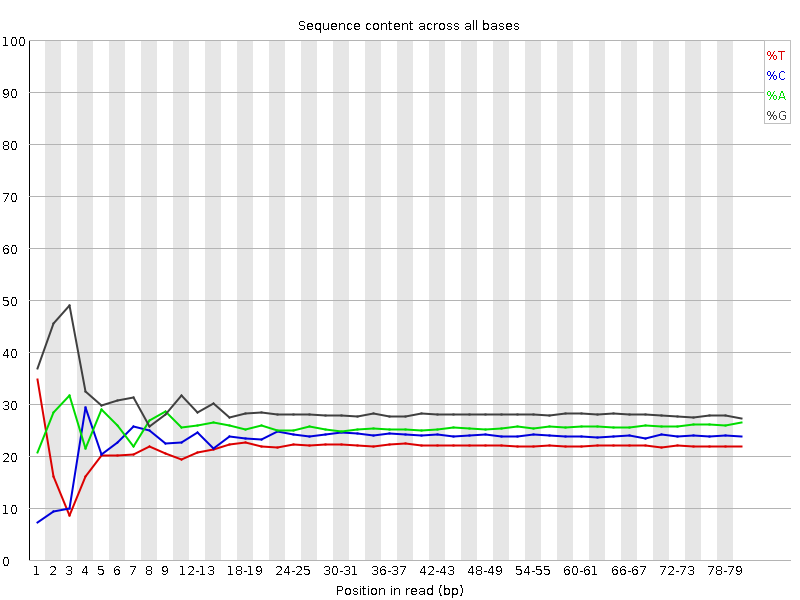

**Per sequence GC content : warn**

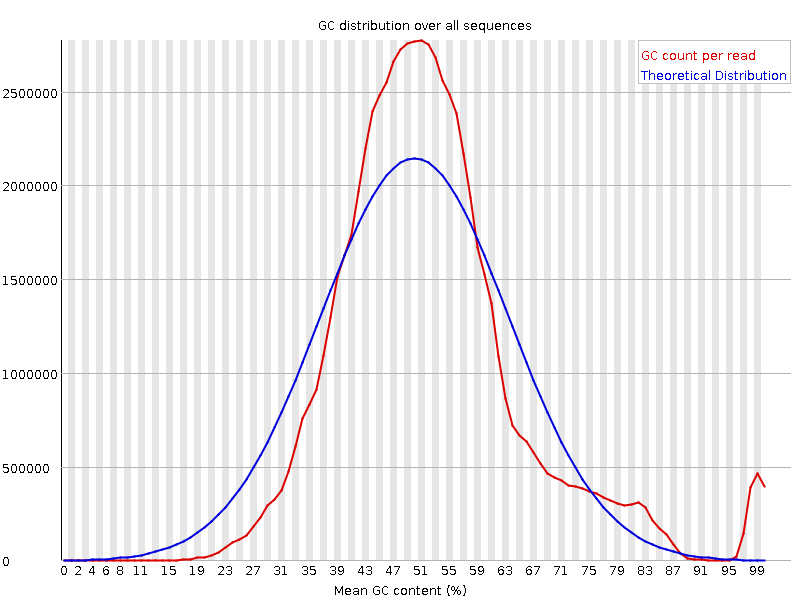

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : warn**

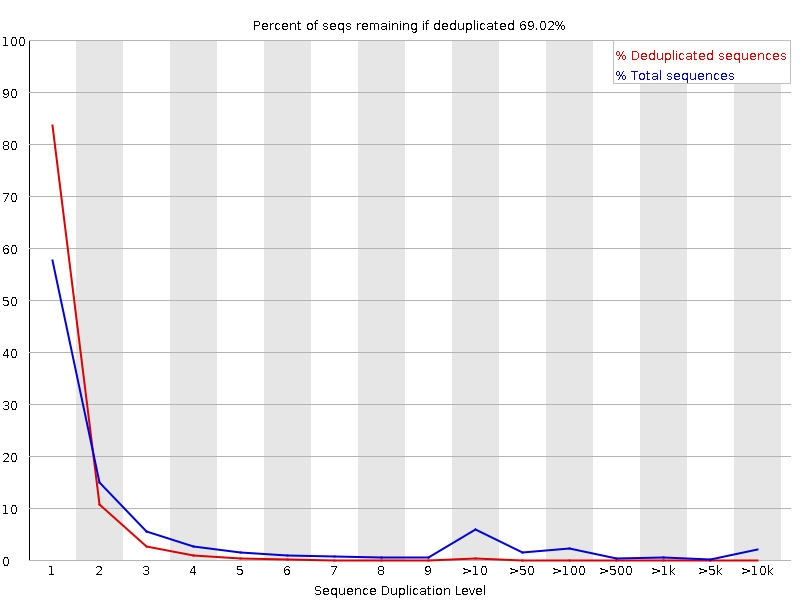

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,393947,0.6797527120346808,No Hit
TGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,268195,0.4627685414640578,No Hit
GTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,176008,0.3037005367214374,No Hit
TTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,154560,0.2666921671495918,No Hit
GGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,88325,0.15240415154948045,No Hit
TGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,63929,0.11030902920358603,No Hit


**Adapter Content : pass**

**Kmer Content : fail**

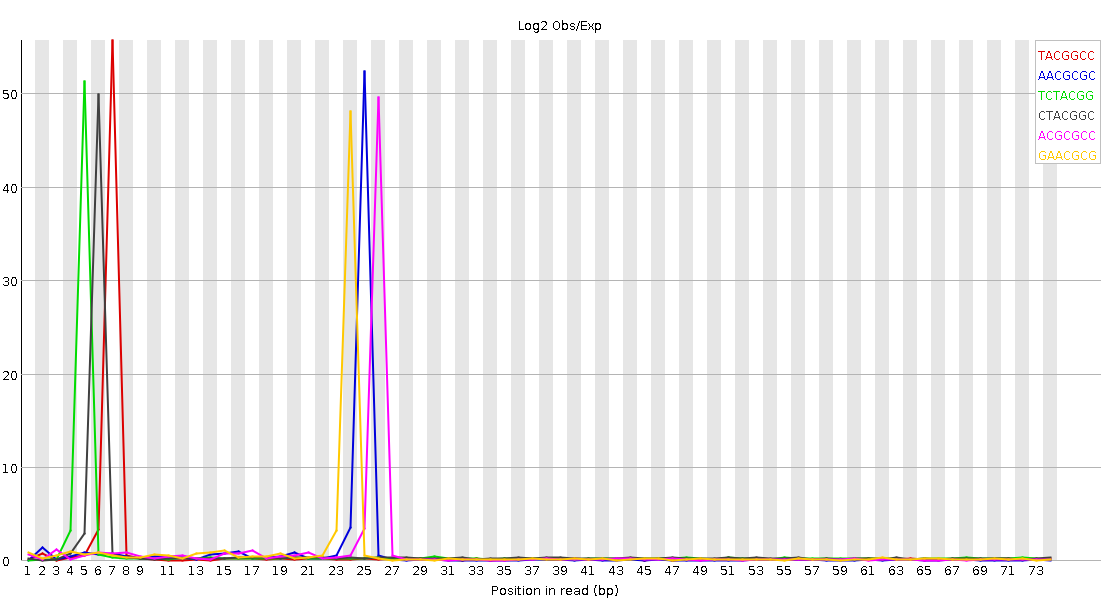

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
TACGGCC,28085,0.0,55.65624,7
AACGCGC,29115,0.0,52.406006,25
TCTACGG,30475,0.0,51.280197,5
CTACGGC,31395,0.0,49.90728,6
ACGCGCC,30880,0.0,49.626442,26
GAACGCG,31770,0.0,48.072723,24
GCCATAC,32950,0.0,47.247265,11
CCCGATC,32495,0.0,46.955513,31
GTCTACG,34230,0.0,46.06553,4
TCTCGTC,33555,0.0,45.362865,36


---
## 40IIR_1_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,40IIR_1.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,68105042
Sequences flagged as poor quality,0
Sequence length,80
%GC,51


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

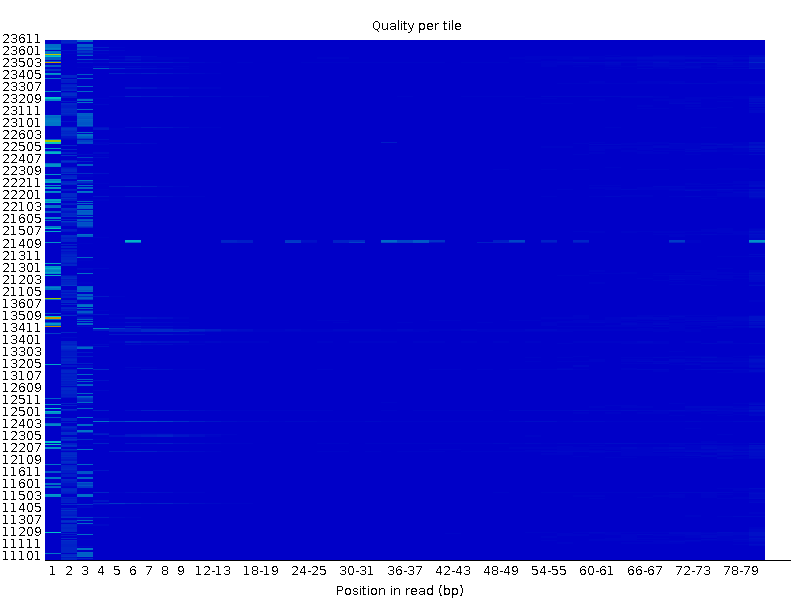

**Per sequence quality scores : pass**

**Per base sequence content : fail**

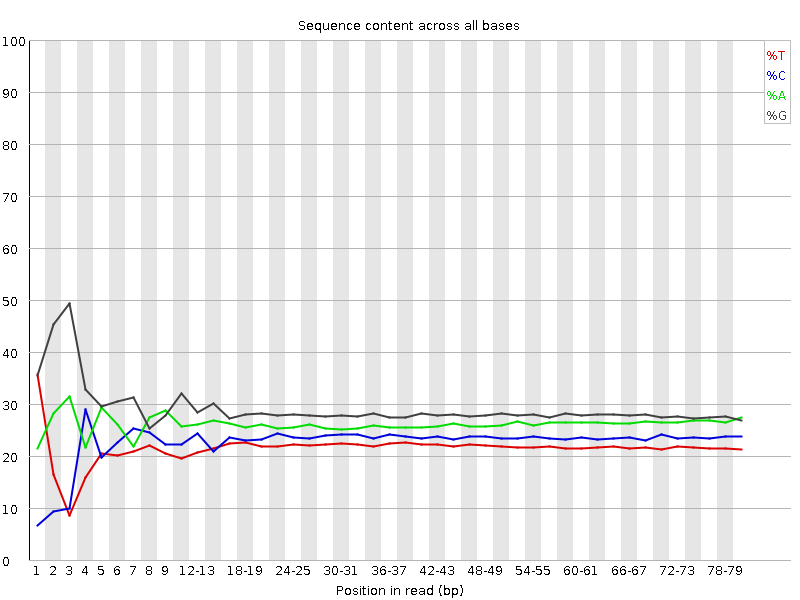

**Per sequence GC content : warn**

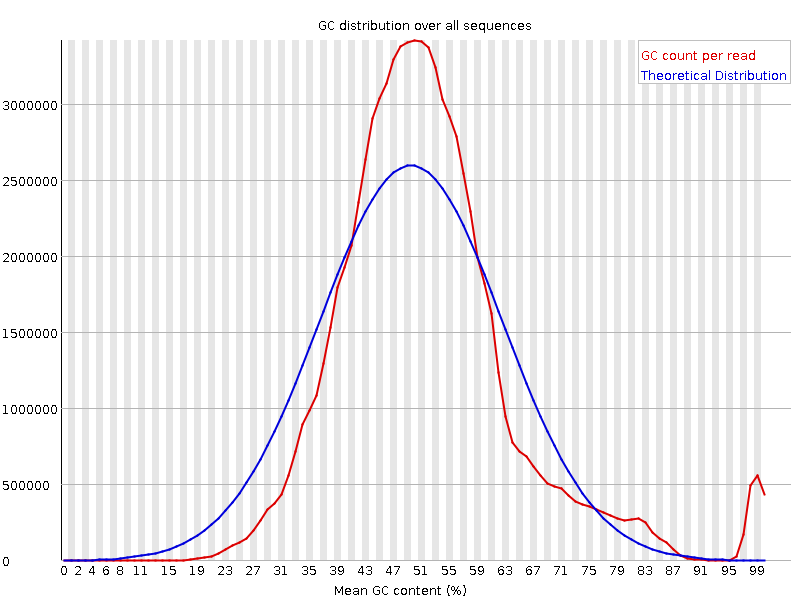

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : warn**

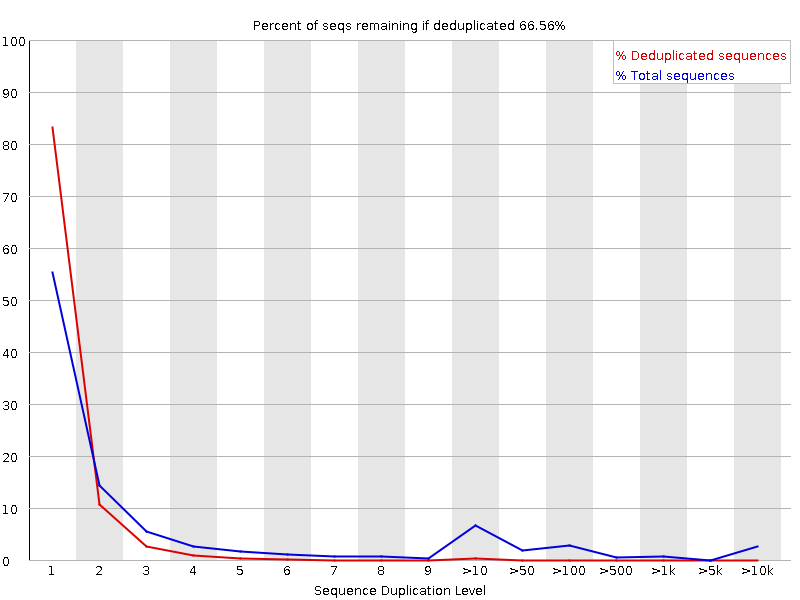

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,438853,0.6443766674426249,No Hit
TGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,353209,0.5186238634138131,No Hit
GTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,223705,0.328470541138496,No Hit
TTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,188717,0.2770969585482379,No Hit
GGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,104646,0.15365382198868624,No Hit
TGTGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,80265,0.11785471037518779,No Hit
GGGGTCTACGGCCATACCACCCTGAACGCGCCCGATCTCGTCTGATCTCG,74197,0.10894494419370596,No Hit


**Adapter Content : warn**

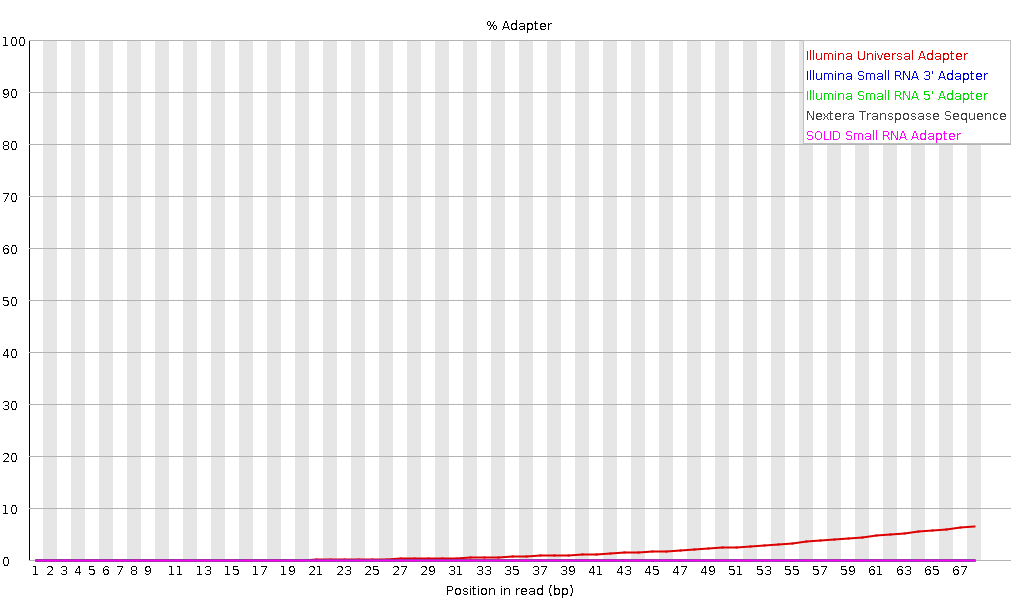

**Kmer Content : fail**

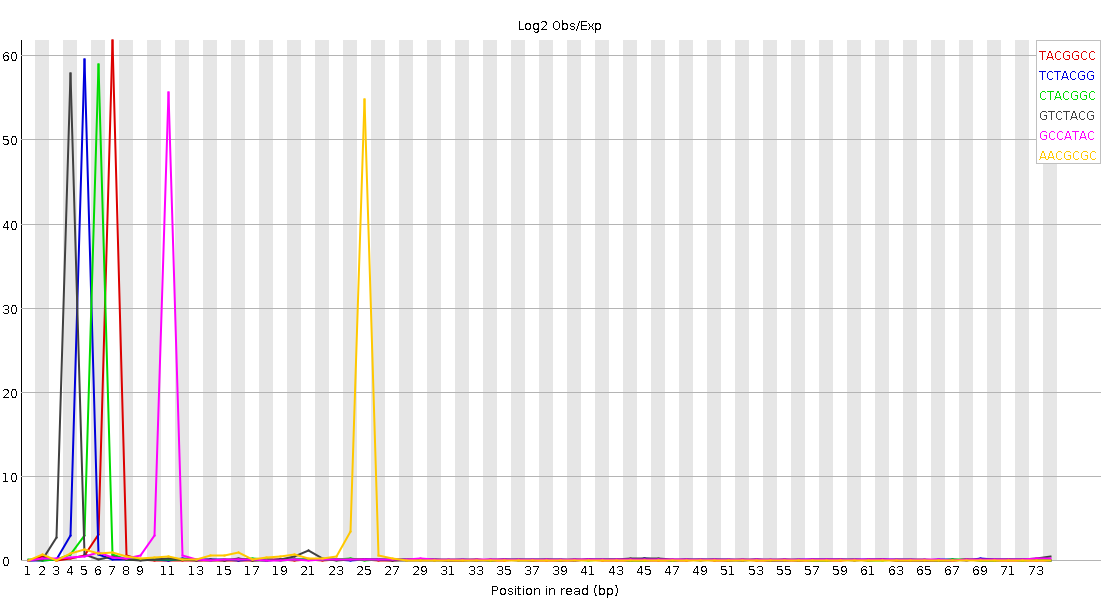

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
TACGGCC,60185,0.0,61.72288,7
TCTACGG,62530,0.0,59.55151,5
CTACGGC,63110,0.0,58.957485,6
GTCTACG,64290,0.0,57.869434,4
GCCATAC,65950,0.0,55.575607,11
AACGCGC,65930,0.0,54.77674,25
CGGCCAT,68695,0.0,54.30259,9
ACGCGCC,67330,0.0,53.67073,26
GGCCATA,69950,0.0,53.434105,10
ACGGCCA,70050,0.0,53.22047,8


---
## 40IIR_2_fastqc.zip

**Basic Statistics : pass**

,Value
Filename,40IIR_2.fastq.gz
File type,Conventional base calls
Encoding,Sanger / Illumina 1.9
Total Sequences,68105042
Sequences flagged as poor quality,0
Sequence length,80
%GC,50


**Per base sequence quality : pass**

**Per tile sequence quality : warn**

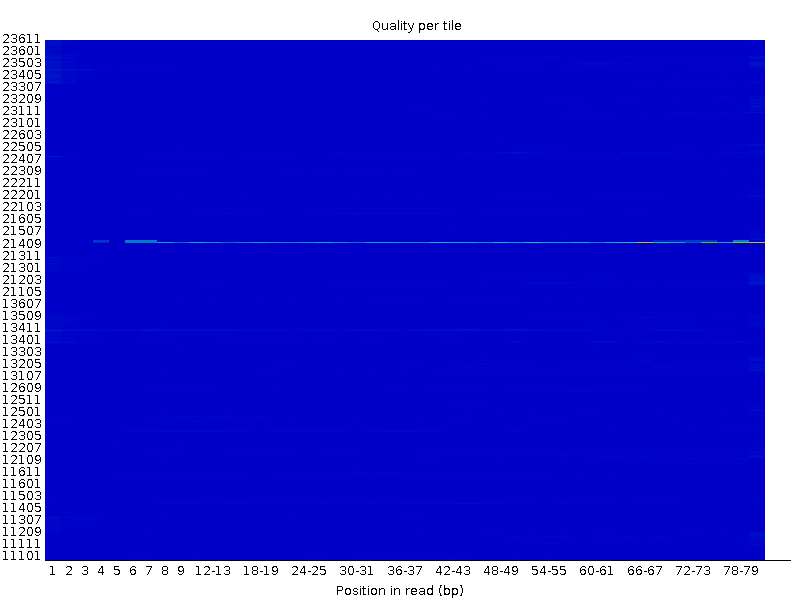

**Per sequence quality scores : pass**

**Per base sequence content : fail**

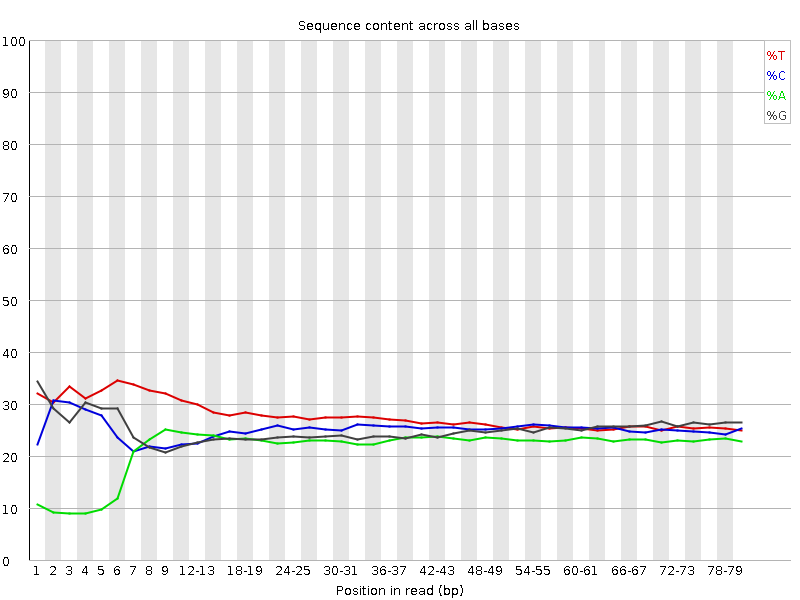

**Per sequence GC content : warn**

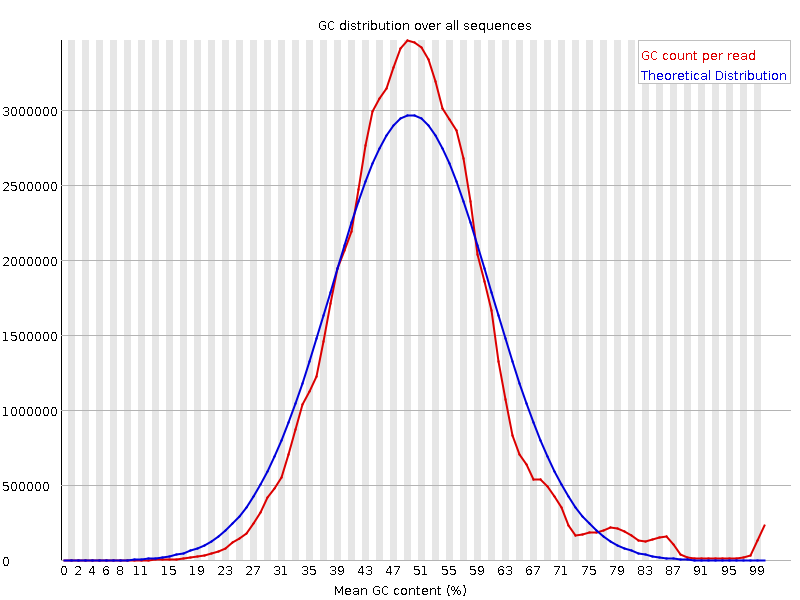

**Per base N content : pass**

**Sequence Length Distribution : pass**

**Sequence Duplication Levels : fail**

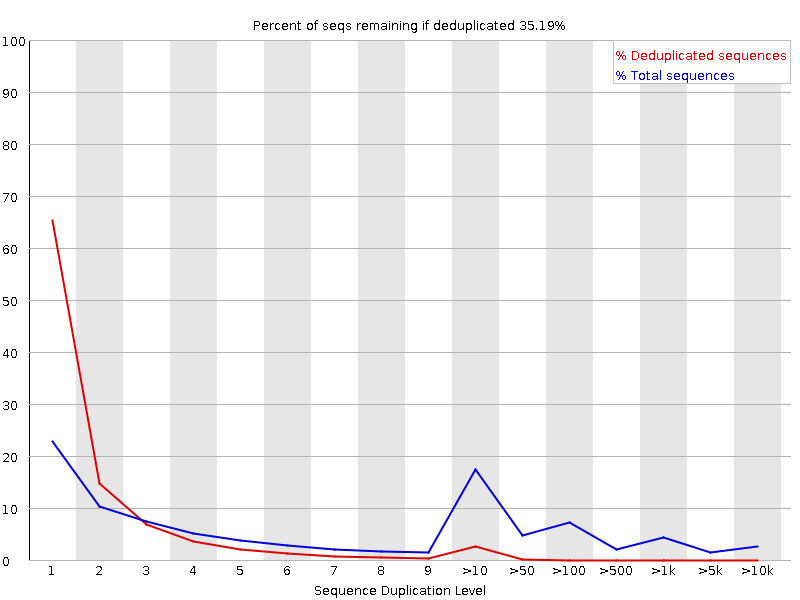

**Overrepresented sequences : warn**

,Count,Percentage,Possible Source
GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG,218788,0.3212508113569624,No Hit
TCCTCTAGATAGTCAAGTTCGACCGTCTTCTCAGCGCTCCGCCAGGGCCG,116204,0.17062466535150217,No Hit


**Adapter Content : warn**

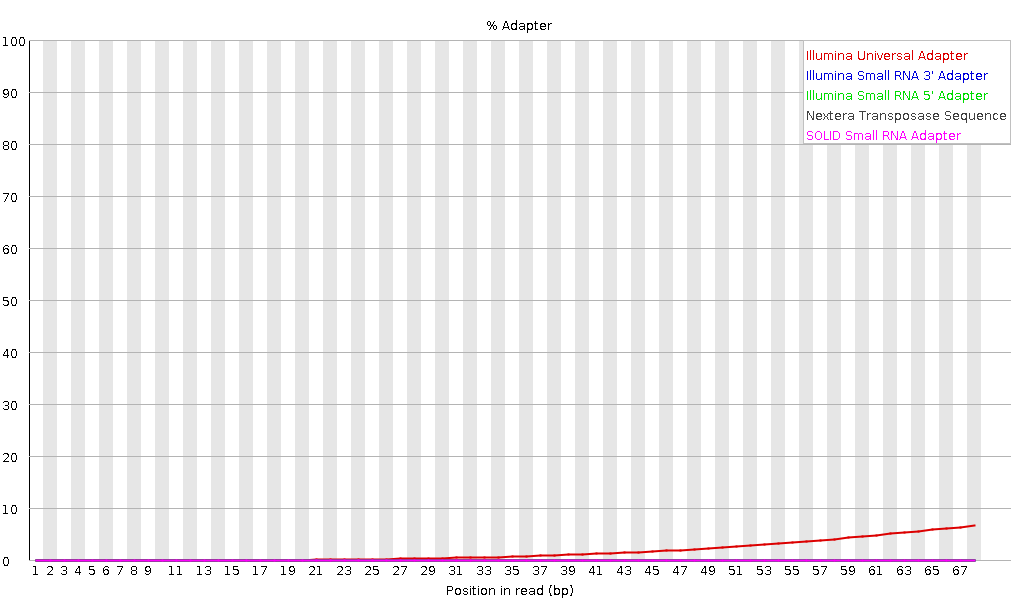

**Kmer Content : fail**

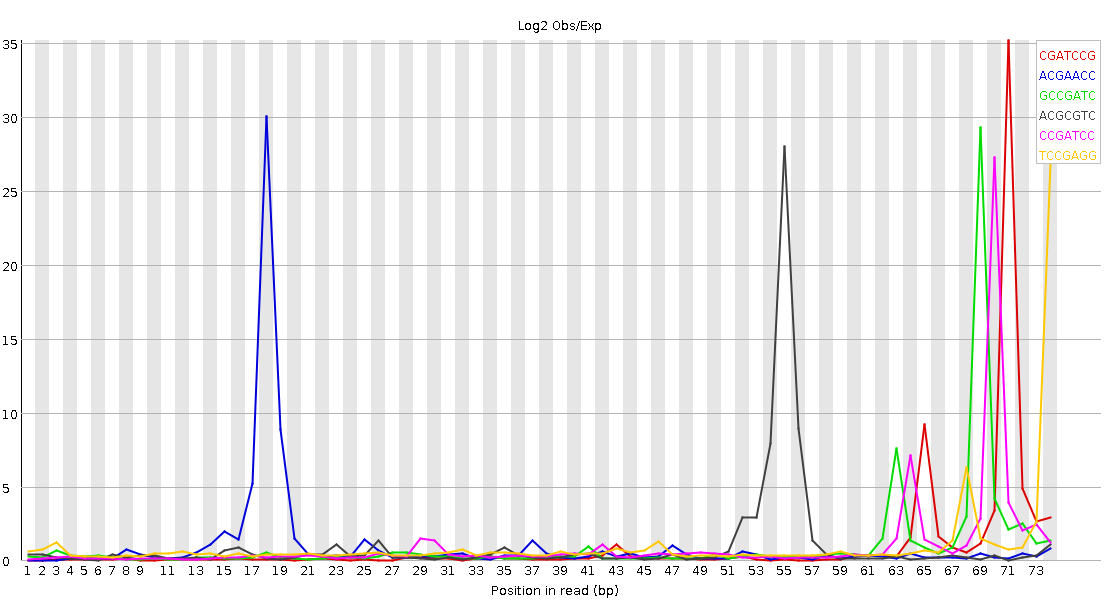

,Count,PValue,Obs/Exp Max,Max Obs/Exp Position
CGATCCG,28290,0.0,35.151955,71
ACGAACC,18125,0.0,30.027237,18
GCCGATC,36810,0.0,29.273514,69
ACGCGTC,15875,0.0,27.998154,55
CCGATCC,39205,0.0,27.259098,70
TCCGAGG,39330,0.0,26.859905,74
CGTAGAC,34705,0.0,26.567833,74
TACCGAC,8240,0.0,26.408894,55
CTACCGA,8495,0.0,26.225855,54
GATCCGA,36170,0.0,26.032408,72


In [2]:
outdir = "./QC/"
pbu.fastqc_summary(outdir, table_if=["pass", "warn", "fail"] , plot_if=["warn", "fail"], max_table_row=10)

The overall quality of the dataset is good, but I found a lot a Overrepresented polyG sequences in all the datasets. The kmer content is also pretty bad. It should not be a problem for the alignment with common RNA aligners

### Alignment with Kalisto quant

In [9]:
# Define a smaller dataset to test alignment
pycl.bash_live("gunzip -c ./data/26IIR_1.fastq.gz | head -n 400000 | gzip -c > ./data/test_1.fa.gz")
pycl.bash_live("gunzip -c ./data/26IIR_2.fastq.gz | head -n 400000 | gzip -c > ./data/test_2.fa.gz")
pycl.bash_live("kallisto-0.43 quant --bias -b 5 --fr-stranded -t 4 -i ./index/gencode_vM10_all_transcripts.idx -o ./alignment/ ./data/test_1.fa.gz ./data/test_2.fa.gz", live="stderr")



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: ./data/test_1.fa.gz
                             ./data/test_2.fa.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 100,000 reads, 79,745 reads pseudoaligned
[quant] estimated average fragment length: 153.705
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 860 rounds
[bstrp] number of EM bootstraps complete: 5



** The rorientation of the reads appears to be fr and not rf as usual...**

In [16]:
# Define parameters
sample_file = "./info/Sample_sheet.tsv"
index_file = "./index/gencode_vM10_all_transcripts.idx"

# read sample sheet
df = pd.read_table(sample_file)

# For each couple of sample 
for id, val in df.iterrows():
    print ("Analysing : {} {}".format(val.stage, val.RNA_sample))
    
    # Prepare the output directory
    outdir = "./alignment/{}_{}/".format(val.stage, val.RNA_sample)
    pycl.mkdir(outdir)
    
    # Prepare the command line
    pycl.bash_live(
        "kallisto-0.43 quant --bias -b 50 --fr-stranded -t 4 -i {} -o {} {} {}".format(index_file, outdir, val.R1_file, val.R2_file),
        live="stderr",
        log_stderr="{}{}_{}_kallisto_report.txt".format(outdir, val.stage, val.RNA_sample))

Analysing : GV-Oocytes 26IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/GV-Oocytes_26IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/26IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/26IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 65,171,330 reads, 50,768,556 reads pseudoaligned
[quant] estimated average fragment length: 152.789
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,352 rounds
[bstrp] number of EM bootstraps complete: 50



Analysing : GV-Oocytes 27IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/GV-Oocytes_27IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/27IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/27IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 59,095,688 reads, 46,575,102 reads pseudoaligned
[quant] estimated average fragment length: 170.308
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,238 rounds
[bstrp] number of EM bootstraps complete: 50



Analysing : GV-Oocytes 42IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/GV-Oocytes_42IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/42IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/42IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 57,954,458 reads, 45,915,565 reads pseudoaligned
[quant] estimated average fragment length: 174.707
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,151 rounds
[bstrp] number of EM bootstraps complete: 50



Analysing : MII-Oocytes 32IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/MII-Oocytes_32IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/32IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/32IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 66,748,506 reads, 51,532,253 reads pseudoaligned
[quant] estimated average fragment length: 148.675
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,225 rounds
[bstrp] number of EM bootstraps complete: 50



Analysing : MII-Oocytes 40IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/MII-Oocytes_40IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/40IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/40IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 68,105,042 reads, 53,662,842 reads pseudoaligned
[quant] estimated average fragment length: 153.386
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,206 rounds
[bstrp] number of EM bootstraps complete: 50



Analysing : MII-Oocytes 41IIR
Creating /home/aleg/Data/Datasets/YTHDF2_Ivayla/alignment/MII-Oocytes_41IIR



[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 117,667
[index] number of k-mers: 103,067,506
[index] number of equivalence classes: 398,688
[quant] running in paired-end mode
[quant] will process pair 1: /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/41IIR_1.fastq.gz
                             /home/aleg/Data/Datasets/YTHDF2_Ivayla/data/41IIR_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] learning parameters for sequence specific bias
[quant] processed 67,864,299 reads, 52,733,298 reads pseudoaligned
[quant] estimated average fragment length: 150.539
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,271 rounds
[bstrp] number of EM bootstraps complete: 50



**Parse the kallisto results**

In [19]:
sample_df = pd.DataFrame(columns = ["Total Reads", "Total read mapped", "% read mapped","Estimated fragment lenght"])
# results obtained with basic alignment using Kallisto quant
for file in glob("./alignment/*/*_kallisto_report.txt"):
    sname = pycl.file_basename(file)[:-16]
    with open (file, "r") as fp: 
        lines = fp.readlines()
        est_len = float(lines[12].split()[-1].replace(",",""))
        total_seq = int(lines[11].split()[2].replace(",",""))
        total_mapped = int(lines[11].split()[4].replace(",",""))
        sample_df.loc[sname]=[total_seq, total_mapped, total_mapped/total_seq*100 , est_len]

sample_df

,Total Reads,Total read mapped,% read mapped,Estimated fragment lenght
MII-Oocytes_32IIR,66748506.0,51532253.0,77.203605,148.675
GV-Oocytes_26IIR,65171330.0,50768556.0,77.900138,152.789
GV-Oocytes_42IIR,57954458.0,45915565.0,79.226977,174.707
MII-Oocytes_41IIR,67864299.0,52733298.0,77.704034,150.539
MII-Oocytes_40IIR,68105042.0,53662842.0,78.794228,153.386
GV-Oocytes_27IIR,59095688.0,46575102.0,78.813029,170.308


** The alignment percentage is decent and very similar between the samples ~ 78 %**

** The length of the fragments is in the range of what is expected with Nextera lib preparation ~ 150 pb**

# Differential expression analysis with Sleuth